# Project Overview

(참고) 목차 최하단 Summary에 결과 요약이 있음

* 개요
    * KNNRegressor과 RandomForestRegressor model을 사용하여 Apple의 historical data를 포함한 몇몇 feature들을 학습시켜, 실제 Apple의 주가를 예측해본다. =======
* 데이터셋
    * 2003년부터 현재까지의 20년 간의 애플 주가 데이터셋을 사용한다.
        * Test dataset은 2023년도의 약 7개월 간의 데이터이고,
        * Train dataset은 2003년부터 2023년 전까지의 약 19년 5개월치의 데이터이다.
    * OLHC 데이터 즉, 시가, 저가, 고가, 종가 데이터와 거래량이 포함된 기본 데이터다.
        * 수정 종가(adjusted close)는 본 프로젝트에서 사용하지 않기로 한다.
* 목적
    * 애플의 내일의 종가를 예측하는 것을 목적으로 한다.
* 방법
    * 종가 자체를 예측하는 문제이므로 회귀문제에 해당한다.
    * "얕은" 머신러닝 알고리즘 사용
        * 비교적으로 학습 시간과 베모리 사용 부담이 적은 얕은 머신러닝 알고리즘을 사용하여 위의 변수들을 제외한 다른 변수들을 추가하였을 떄 학습 성능이 향상되는지 확인한다. 최종적으로 확정된 독립변수들을 사용하여서는 다양한 하이퍼파라미터를 튜닝하여 최적의 모델을 찾는 것을 목적으로 한다.
        * 알고리즘#1. K Nearest Neighbors - Regressor
        * 알고리즘#2. 앙상블 모델로서의 Random Forest - Regressor
    * 딥러닝 알고리즘 사용
        * 시계열 자료 학습에 특화된 순환 신경망 모델(RNN) 중 가장 대표적인 LSTM 알고리즘을 사용하여 다양한 하이퍼파라미터 튜닝을 통해 최적의 성능을 내는 모델을 찾는다. 특히, RNN 알고리즘인 LSTM의 장점을 살리기 위해 얼마나 과거의 데이터를 바탕으로 다음 스텝을 예측할 때 좋은 성능을 보이는지 확인한다.
        * 알고리즘#1. Long Short Term Memory (LSTM)
    * --> 가장 최근까지의 데이터(i.e. 2022-12-31까지의)를 바탕으로 모델을 학습시키고, 그 모델로 오늘의 데이터를 test data로 사용하여 내일의 종가를 예측하는 모델을 설계하기 위해 주가 예측에 가장 많이 사용되는 것으로 알려진 위의 세 가지 머신러닝 알고리즘을 사용한다.
    * (참고) 실제로 이 모델을 사용할 때는 매일 모델을 업데이트하여 어제까지의 데이터로 학습된 모델을 사용하여, 오늘의 데이터를 X test로 사용하여 내일의 종가 즉 y-hat을 예측하게 될 것이다.

# Libraries Used

In [ ]:
# Basics
import os
import random
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

# Data downloading library
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Shallow learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, TimeSeriesSplit

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Metrics
import sklearn.metrics as metrics
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError, BinaryAccuracy, Precision, Recall, AUC

# Config

In [ ]:
# import os
# import random
# import numpy as np
# import torch

def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

seed_everything(42) # Seed 고정

# Raw Dataset

### Downloading data

야후 파이넨스에서는 라이브러리를 통해 실시간 주가 데이터를 제공한다.

우리는 이 라이브러리를 사용하여 데이터를 다운로드 받았다.

In [ ]:
# 아래와 같이 20년치의 애플 주가 데이터를 다운받는다
yesterday = datetime.now() - relativedelta(days=1)  # 어제 날짜
term = 20   # 20년치 데이터

start = yesterday - relativedelta(years=term)   # 어제로부터 20년 전부터...
end = yesterday # ...어제까지의 데이터

last_update = yf.download('AAPL',
                    start = start,
                    end = end,
                    interval = "1d",
                    auto_adjust = True,
                    progress = False)

In [ ]:
df = last_update.copy()
df

,Open,High,Low,Close,Volume
Date,,,,,
2003-08-11,0.300819,0.302489,0.296114,0.298390,137228000
2003-08-12,0.299908,0.300515,0.295355,0.298998,164438400
2003-08-13,0.301426,0.308711,0.297177,0.306283,284099200
2003-08-14,0.306739,0.308560,0.302640,0.303096,192780000
2003-08-15,0.303855,0.304614,0.298390,0.299149,125865600
...,...,...,...,...,...
2023-08-04,185.520004,187.380005,181.919998,181.990005,115799700
2023-08-07,182.130005,183.130005,177.350006,178.850006,97576100
2023-08-08,179.690002,180.270004,177.580002,179.800003,67823000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2003-08-11 to 2023-08-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5035 non-null   float64
 1   High    5035 non-null   float64
 2   Low     5035 non-null   float64
 3   Close   5035 non-null   float64
 4   Volume  5035 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.0 KB


### Basic EDA

In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,5035.000000,5035.000000,5035.000000,5035.000000,5.035000e+03
mean,37.890584,38.312862,37.484208,37.915060,4.111100e+08
std,49.637831,50.220289,49.096780,49.681768,3.946116e+08
min,0.298239,0.300515,0.292168,0.298390,3.145820e+07
25%,4.239696,4.293728,4.169880,4.240455,1.183631e+08
50%,17.331546,17.442643,17.155799,17.314104,2.782696e+08
75%,42.645031,43.325823,42.378472,42.587629,5.762904e+08
max,196.240005,198.229996,195.279999,196.449997,3.372970e+09


* 애플 주가는 최근 20년 사이에 종가 기준 최저 0.30 달러에서 최고 196.45 달러로 올랐다.
* 특히 최근 5년 사이의 주가가 크게 올라 변동폭이 크다.
* 이러한 추세는 아래 그래프에서도 확인할 수 있다.

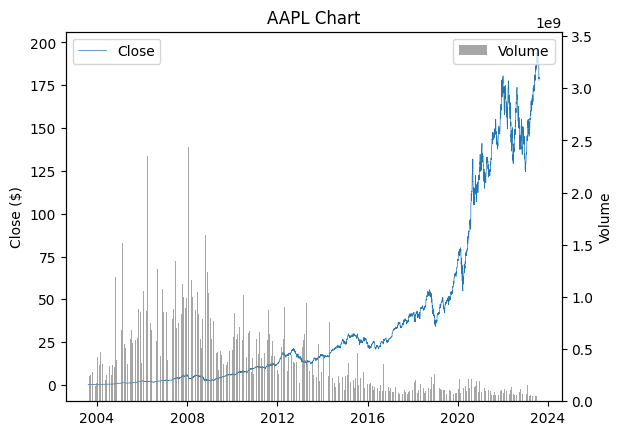

In [ ]:
plt.plot(df.index, df["Close"], linewidth=0.5, label="Close")
plt.ylabel("Close ($)")
plt.legend(loc="upper left")

plt.twinx()
plt.bar(df.index, df["Volume"], color="gray", alpha=0.7, label="Volume")
plt.title("AAPL Chart")
plt.ylabel("Volume")
plt.legend(loc="upper right")
plt.show()

#### Correlations

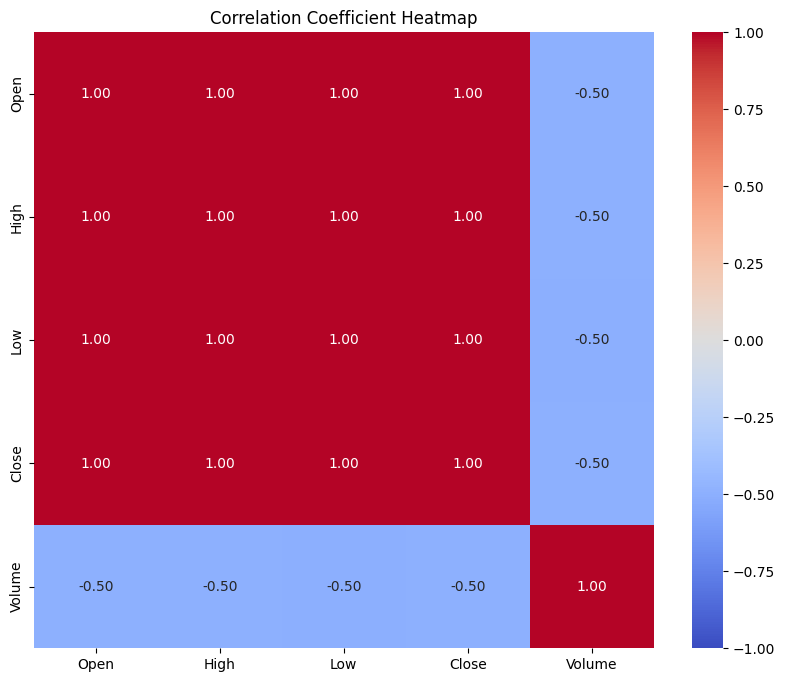

% of highly correlated pairs: 56.0 %


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            fmt='.2f')

# Add a title to the heatmap
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()

# Find pairs of columns with correlation coefficients >= 0.5 or <= -0.5
high_corr = 0
num_cols = len(df.columns)
for column1 in correlation_matrix.columns:
    for column2 in correlation_matrix.columns:
        if column1 != column2 and abs(correlation_matrix.loc[column1, column2]) >= 0.5:
            high_corr += 1
print(f"% of highly correlated pairs: {high_corr/(num_cols**2)*100:.1f} %")

Volume을 제외한 모든 feature variable들은 당일의 주가를 표현하기 때문에 서로 상관관계가 높음을 확인할 수 있다(상관계수 1.0)

#### Data distribution of each columns

<Axes: >

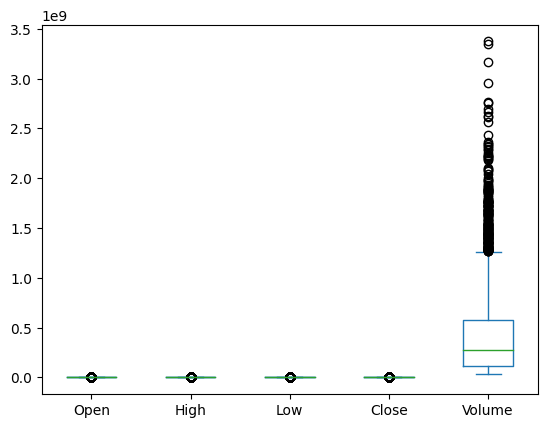

In [ ]:
df.plot.box()

* OLHC와 Volume의 raw 값들의 분산을 비교했을 때, 상대적으로 Volume의 분산이 매우 큼을 확인 할 수 있다.
* 이는 volume 자체의 분산이 큰 것일 수도 있지만 서로 단위가 달라서 더욱 비교되는 것이기도 하다.
* 따라서 공평한 비교를 위해 Scaling 과정이 필요하다.
* 주가 분석 및 예측에서는 Standard scaling과 Min-Max Scaling 모두 비슷하게 사용되고 있으나 우리는 Standard Scaler를 사용하기로 한다.

# Shallow Learning

* 주가에 영향을 줄 것으로 예측되는 아래와 같은 요소들을 추가해 모델 성능 향상 여부를 확인해보았다.
    * Dow futures
    * S&P500
    * S&P500
    * Nasdaq 100
    * Nasdaq futures
    * CBOE Volatility Index(뉴욕 주식시장 변동성 지수)
    * 미국 13주 만기 국채 이자율(Treasury interest rates(5W))
    * 미국 5년 만기 국채 이자율(Treasury interest rates(5Y))
    * 미국 10년 만기 국채 이자율(Treasury interest rates(10Y))
    * US dollar index(세계 주요 6개국 통화에 대비 미국 달러의 평균적인 가치를 나타내는 지표)
    * Crude Oil(원유 선물)
* 모델 성능 향상에 유의미한 영향을 주는 요소들은 다음과 같았다:
    * S&P500 futures
    * Nasdaq futures
    * VIX
    * Crude Oil

* 특히 최근 주가가 금리의 영향을 많이 받아 미국채 이자율(금리)이 모델 성능 향상을 기대하며 변수로 추가하였지만, 오히려 성능을 떨어뜨리는 결과를 보였다.  

### Dataset

In [ ]:
yesterday = datetime.now() - relativedelta(days=1)  # 어제 날짜
term = 20   # 기간 (years)

start = yesterday - relativedelta(years=term)
end = yesterday

last_update = yf.download('AAPL',
                    start = start,
                    end = yesterday,
                    interval = "1d",
                    auto_adjust = True,
                    progress = False)

In [ ]:
df = last_update.copy()
df

,Open,High,Low,Close,Volume
Date,,,,,
2003-08-12,0.299504,0.300110,0.294957,0.298595,164438400
2003-08-13,0.301020,0.308295,0.296776,0.305870,284099200
2003-08-14,0.306325,0.308144,0.302232,0.302687,192780000
2003-08-15,0.303445,0.304203,0.297988,0.298746,125865600
2003-08-18,0.301020,0.309356,0.298898,0.308295,192774400
...,...,...,...,...,...
2023-08-07,181.884386,182.883037,177.110833,178.608810,97576100
2023-08-08,179.447673,180.026893,177.340518,179.557526,67823000
2023-08-09,180.626086,180.686002,176.771290,177.949707,60378500


"변동률" Column 추가

In [ ]:
# 일 등락률 = (오늘종가 – 어제종가) / 어제종가 * 100
df["Change"] = df["Close"].pct_change() * 100
df = df.iloc[1:, :]
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2003-08-13,0.301020,0.308295,0.296776,0.305870,284099200,2.436438
2003-08-14,0.306325,0.308144,0.302232,0.302687,192780000,-1.040632
2003-08-15,0.303445,0.304203,0.297988,0.298746,125865600,-1.301976
2003-08-18,0.301020,0.309356,0.298898,0.308295,192774400,3.196359
2003-08-19,0.308750,0.309963,0.303142,0.307992,133688800,-0.098331
...,...,...,...,...,...,...
2023-08-07,181.884386,182.883037,177.110833,178.608810,97576100,-1.725373
2023-08-08,179.447673,180.026893,177.340518,179.557526,67823000,0.531169
2023-08-09,180.626086,180.686002,176.771290,177.949707,60378500,-0.895434


In [ ]:
# feature 추가 함수
def addFeature(df, ticker, colName):
    new_feature = yf.download(ticker,
                    start = start,
                    end = end,
                    progress = False)

    df[colName] = new_feature["Close"]

    return df

선별한 Feature들 추가

In [ ]:
# Dow futures: YM=F
# S&P500: ^GSPC
# S&P500 futures: ES=F
# Nasdaq 100: ^NDX
# Nasdaq futures: NQ=F
# CBOE Volatility Index(뉴욕 주식시ㅡ장 변동성 지수): ^VIX
# 미국 13주 만기 국채 이자율(Treasury interest rates(5W)):^IRX
# 미국 5년 만기 국채 이자율(Treasury interest rates(5Y)): ^FVX
# 미국 10년 만기 국채 이자율(Treasury interest rates(10Y)): ^TNX
# US dollar index(세계 주요 6개국 통화에 대비 미국 달러의 평균적인 가치를 나타내는 지표): DX-Y.NYB
# Crude Oil(원유 선물): CL=F

#addFeature(df, ticker="YM-F", colName="Dow")
#addFeature(df, ticker="^GSPC", colName="S&P500")
addFeature(df, ticker="ES=F", colName="S&P500 futures")
#addFeature(df, ticker="^NDX", colName="Nasdaq")
addFeature(df, ticker="NQ=F", colName="Nasdaq futures")
addFeature(df, ticker="^VIX", colName="VIX")
#addFeature(df, ticker="^IRX", colName="Treasury interest rates(5W)")
#addFeature(df, ticker="^FVX", colName="Treasury interest rates(5)")
#addFeature(df, ticker="^TNX", colName="Treasury interest rates(10)")
#addFeature(df, ticker="DX-Y.NYB", colName="US dollar index")
addFeature(df, ticker="CL=F", colName="Crude Oil")

# pandas warining ignore
pd.set_option('mode.chained_assignment',  None)

df

,Open,High,Low,Close,Volume,Change,S&P500 futures,Nasdaq futures,VIX,Crude Oil
Date,,,,,,,,,,
2003-08-13,0.301020,0.308295,0.296776,0.305870,284099200,2.436438,984.75,1243.00,18.770000,30.780001
2003-08-14,0.306325,0.308144,0.302232,0.302687,192780000,-1.040632,987.75,1245.50,18.469999,31.090000
2003-08-15,0.303445,0.304203,0.297988,0.298746,125865600,-1.301976,990.50,1254.50,18.270000,31.049999
2003-08-18,0.301020,0.309356,0.298898,0.308295,192774400,3.196359,998.75,1287.00,18.180000,30.889999
2003-08-19,0.308750,0.309963,0.303142,0.307992,133688800,-0.098331,1003.00,1302.50,17.860001,30.700001
...,...,...,...,...,...,...,...,...,...,...
2023-08-07,181.884386,182.883037,177.110833,178.608810,97576100,-1.725373,4537.75,15485.50,15.770000,81.940002
2023-08-08,179.447673,180.026893,177.340518,179.557526,67823000,0.531169,4518.50,15354.25,15.990000,82.919998
2023-08-09,180.626086,180.686002,176.771290,177.949707,60378500,-0.895434,4485.75,15178.25,15.960000,84.400002


결측치 확인 및 제거

In [ ]:
df.isnull().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
Change             0
S&P500 futures     2
Nasdaq futures     2
VIX                0
Crude Oil         10
dtype: int64

In [ ]:
df = df.dropna(axis=0)
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Volume            0
Change            0
S&P500 futures    0
Nasdaq futures    0
VIX               0
Crude Oil         0
dtype: int64

target의 column을 맨 앞으로 정렬

In [ ]:
def setColumns(df):
    columns = list(df.columns)
    columns.remove("Close")
    columns.insert(0, "Close")
    df = df[columns]

    return df

df = setColumns(df)
df

,Close,Open,High,Low,Volume,Change,S&P500 futures,Nasdaq futures,VIX,Crude Oil
Date,,,,,,,,,,
2003-08-13,0.305870,0.301020,0.308295,0.296776,284099200,2.436438,984.75,1243.00,18.770000,30.780001
2003-08-14,0.302687,0.306325,0.308144,0.302232,192780000,-1.040632,987.75,1245.50,18.469999,31.090000
2003-08-15,0.298746,0.303445,0.304203,0.297988,125865600,-1.301976,990.50,1254.50,18.270000,31.049999
2003-08-18,0.308295,0.301020,0.309356,0.298898,192774400,3.196359,998.75,1287.00,18.180000,30.889999
2003-08-19,0.307992,0.308750,0.309963,0.303142,133688800,-0.098331,1003.00,1302.50,17.860001,30.700001
...,...,...,...,...,...,...,...,...,...,...
2023-08-07,178.608810,181.884386,182.883037,177.110833,97576100,-1.725373,4537.75,15485.50,15.770000,81.940002
2023-08-08,179.557526,179.447673,180.026893,177.340518,67823000,0.531169,4518.50,15354.25,15.990000,82.919998
2023-08-09,177.949707,180.626086,180.686002,176.771290,60378500,-0.895434,4485.75,15178.25,15.960000,84.400002


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5024 entries, 2003-08-13 to 2023-08-11
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           5024 non-null   float64
 1   Open            5024 non-null   float64
 2   High            5024 non-null   float64
 3   Low             5024 non-null   float64
 4   Volume          5024 non-null   int64  
 5   Change          5024 non-null   float64
 6   S&P500 futures  5024 non-null   float64
 7   Nasdaq futures  5024 non-null   float64
 8   VIX             5024 non-null   float64
 9   Crude Oil       5024 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 431.8 KB


In [ ]:
df.describe()

,Close,Open,High,Low,Volume,Change,S&P500 futures,Nasdaq futures,VIX,Crude Oil
count,5024.000000,5024.000000,5024.000000,5024.000000,5.024000e+03,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000
mean,37.969819,37.945359,38.368047,37.538542,4.114543e+08,0.147134,2073.796967,4971.126729,19.207998,69.201047
std,49.680403,49.636234,50.218309,49.095863,3.949106e+08,2.099267,1047.117142,4138.345600,8.747918,22.997663
min,0.298595,0.297837,0.301475,0.291774,3.145820e+07,-17.919522,676.000000,1039.500000,9.140000,-37.630001
25%,4.252925,4.248378,4.330226,4.193586,1.183088e+08,-0.867287,1252.397491,1800.437500,13.460000,50.930000
50%,17.308473,17.328635,17.460995,17.174757,2.786938e+08,0.107953,1676.500000,3107.250000,16.755000,66.674999
75%,42.922029,42.852690,43.421892,42.361040,5.781069e+08,1.209987,2729.812500,6974.062500,22.209999,87.707499
max,196.185074,195.975362,197.962667,195.016650,3.372970e+09,13.904917,4786.000000,16575.000000,82.690002,145.289993


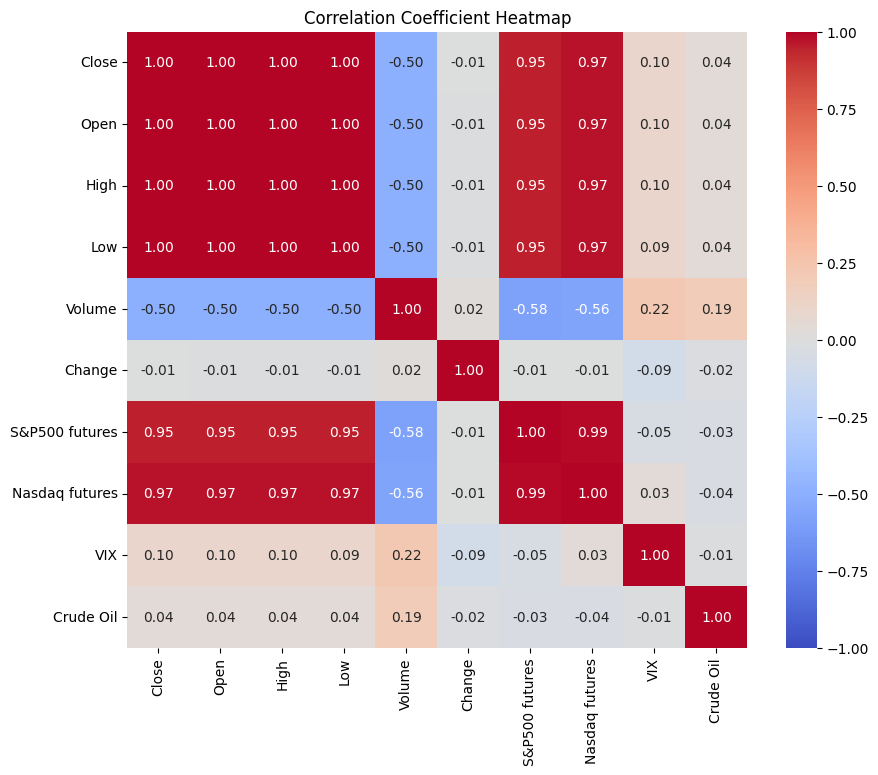

% of highly correlated pairs: 42.0 %


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            fmt='.2f')

# Add a title to the heatmap
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()

# Find pairs of columns with correlation coefficients >= 0.5 or <= -0.5
high_corr = 0
num_cols = len(df.columns)
for column1 in correlation_matrix.columns:
    for column2 in correlation_matrix.columns:
        if column1 != column2 and abs(correlation_matrix.loc[column1, column2]) >= 0.5:
            high_corr += 1
print(f"% of highly correlated pairs: {high_corr/(num_cols**2)*100:.1f} %")

* 일반적으로 feature들 간의 공분산이 높으면 redundant한 feature이므로 제거하곤 한다.
* 그러나 OLHC는 주가 예측 모델에서 흔히 쓰는 변수들이므로 제거하지 않기로 한다.
* S&P500 futures와 Nasdaq futures 간의 공분산도 높지만, 이 변수들은 애플을 포함한 전반적인 미국 주식 시장을 가장 잘 대변하는 지수이므로 이들 또한 제거하지 않기로 한다.

<Axes: >

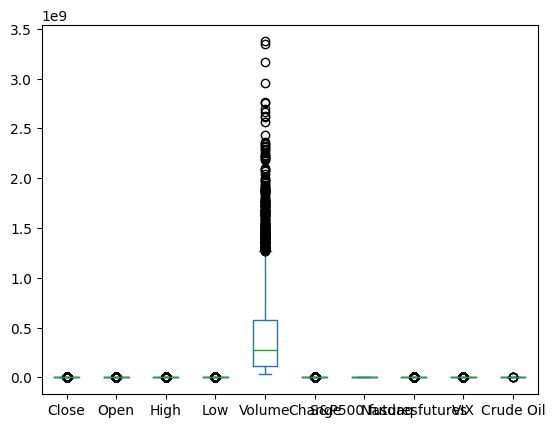

In [ ]:
df.plot.box()

앞에서 언급한 바와 같이 새로운 변수들을 추가한 뒤에도 여전히 Volume의 분산가 다른 변수들에 비해 너무 크기 때문에 학습을 하려면 Scaling이 필요하다.

### KNN

#### With five basic features
* 'Close', 'Open', 'High', 'Low', 'Volume'

Features = ['Close', 'Open', 'High', 'Low', 'Volume'] 

***************** Neighbors = 5 *******************
MAE:            4.9101982518246325
RMSE:           54.9869701325532
R^2:            0.8383529486339698


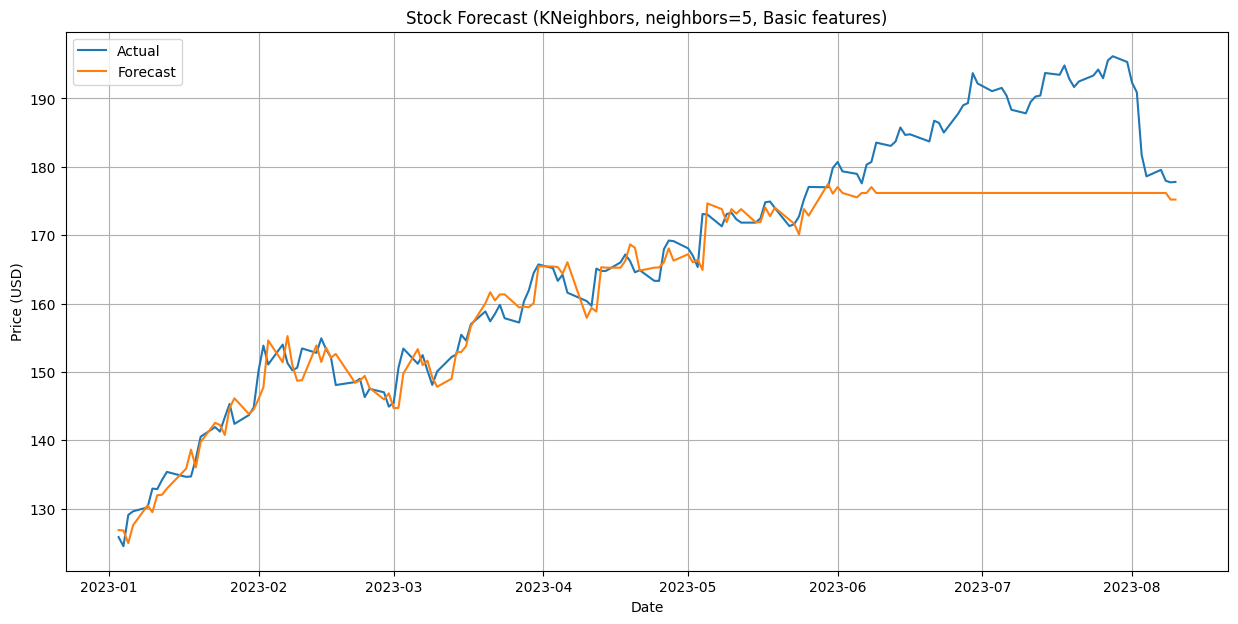

In [ ]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X_raw = df.iloc[:-1, :5]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train_raw = X_raw[X_raw.index.year < 2023].values
X_test_raw = X_raw[X_raw.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X_raw[X_raw.index.year == 2023].index

# 스케일링
scaler = MinMaxScaler()
X_train_knn = scaler.fit_transform(X_train_raw)
X_test_knn = scaler.transform(X_test_raw)

# K 최근접 이웃 회귀 모델 훈련
kn = KNeighborsRegressor(n_neighbors=5)
kn.fit(X_train_knn, y_train)

# 모델을 사용하여 예측 수행
yhat = kn.predict(X_test_knn)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = kn.score(X_test_knn, y_test)

# 결과 출력
print(f'Features = {list(X_raw.columns)} \n')
print(f'***************** Neighbors = {5} *******************')
print(f'MAE:            {mae}')
print(f'RMSE:           {mse}')
print(f'R^2:            {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (KNeighbors, neighbors=5, Basic features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

예측을 하다가 특정시점부터 포기해버린다, "내일의 종가는 오늘과 같을 거야"라고 예측해버리는 듯한 Forecast값이 오른쪽으로 밀린(후행예측(?))을 하는 듯한 느낌이다

#### With aditional features
* 추가한 변수들: 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'

Features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

***************** Neighbors = 5 *******************
MAE:            5.626012922588147
RMSE:           59.972226387197175
R^2:            0.8236976226190131


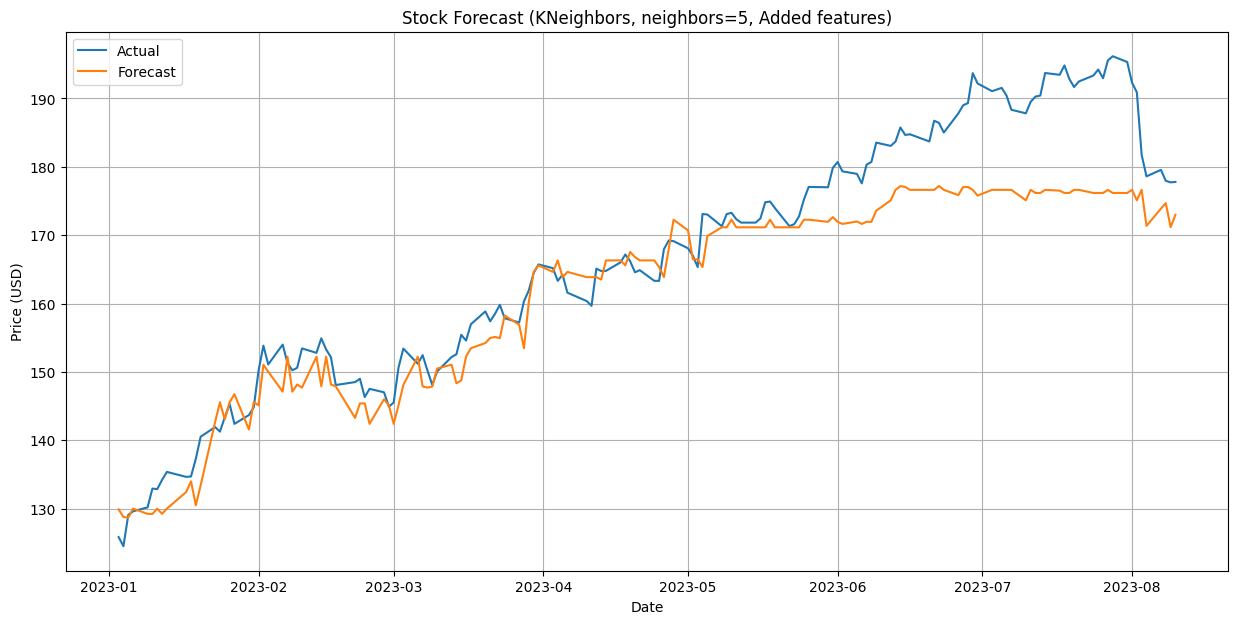

In [ ]:
# feature를 추가하여 다시 학습

# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X[X.index.year == 2023].index

# 스케일링
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

# K 최근접 이웃 회귀 모델 훈련
kn = KNeighborsRegressor(n_neighbors=5)
kn.fit(X_train_, y_train)

# 모델을 사용하여 예측 수행
yhat = kn.predict(X_test_)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = kn.score(X_test_, y_test)

# 결과 출력
print(f'Features = {list(X.columns)} \n')
print(f'***************** Neighbors = {5} *******************')
print(f'MAE:            {mae}')
print(f'RMSE:           {mse}')
print(f'R^2:            {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (KNeighbors, neighbors=5, Added features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

feature들을 추가한 결과, 후행예측하는 듯한 느낌이 비교적 사라졌지만, 정확도는 더 떨어졌다; 이전과 같이 특정시점부터 예측을 못한다.

##### Hyperparameter tunning (GridSearchCV)
GridSearchCV를 사용하여 최적의 하이퍼파라미터 조합 찾기.

Features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

Best Parameter: {'n_neighbors': 52} 

***************** Neighbors = 52 *******************
MAE:            5.626012922588147
RMSE:           59.972226387197175
R^2:           0.8236976226190131


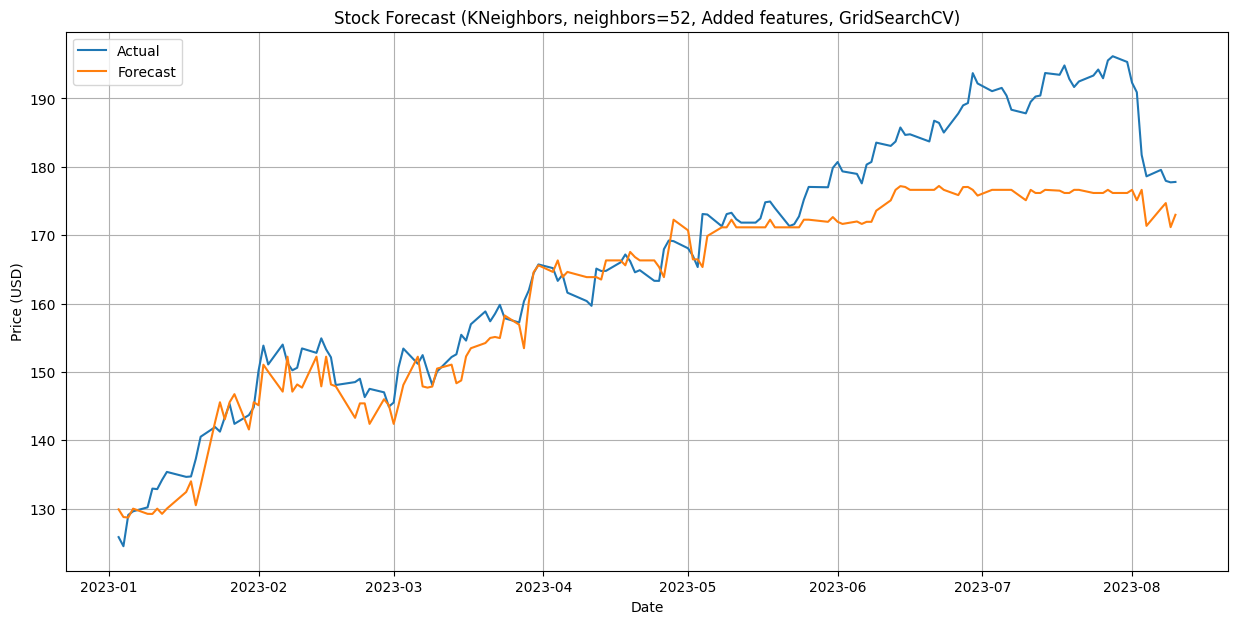

In [ ]:
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

X_test_idx = X[X.index.year == 2023].index

scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

params = {"n_neighbors": [i for i in range(2, 101, 2)]}

kn = KNeighborsRegressor()
kn.fit(X_train_, y_train)
grid_cv = GridSearchCV(kn, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train,y_train)

n_neighbors = grid_cv.best_params_['n_neighbors']

yhat = kn.predict(X_test_)
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = kn.score(X_test_, y_test)

print(f'Features = {list(X.columns)} \n')
print(f"Best Parameter: {grid_cv.best_params_} \n")
print(f'***************** Neighbors = {n_neighbors} *******************')
print(f'MAE:            {mae}')
print(f'RMSE:           {mse}')
print(f'R^2:           {R2}')

plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title(f"Stock Forecast (KNeighbors, neighbors={n_neighbors}, Added features, GridSearchCV)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

GridSearchCV를 통해 최적의 하이퍼파라미터값을 찾아 적용시켜주었다. 최적의 값은 n_neighbors=52로 나왔지만 기존 n_neighbors=5와 성능이 비슷해 의미가 없다.

### RandomForest

#### With five basic features
* 'Close', 'Open', 'High', 'Low', 'Volume'

Features = ['Close', 'Open', 'High', 'Low', 'Volume'] 

MAE:           5.073443598998222
MSE:           60.75784469648857
R^2:           0.8213881139683276


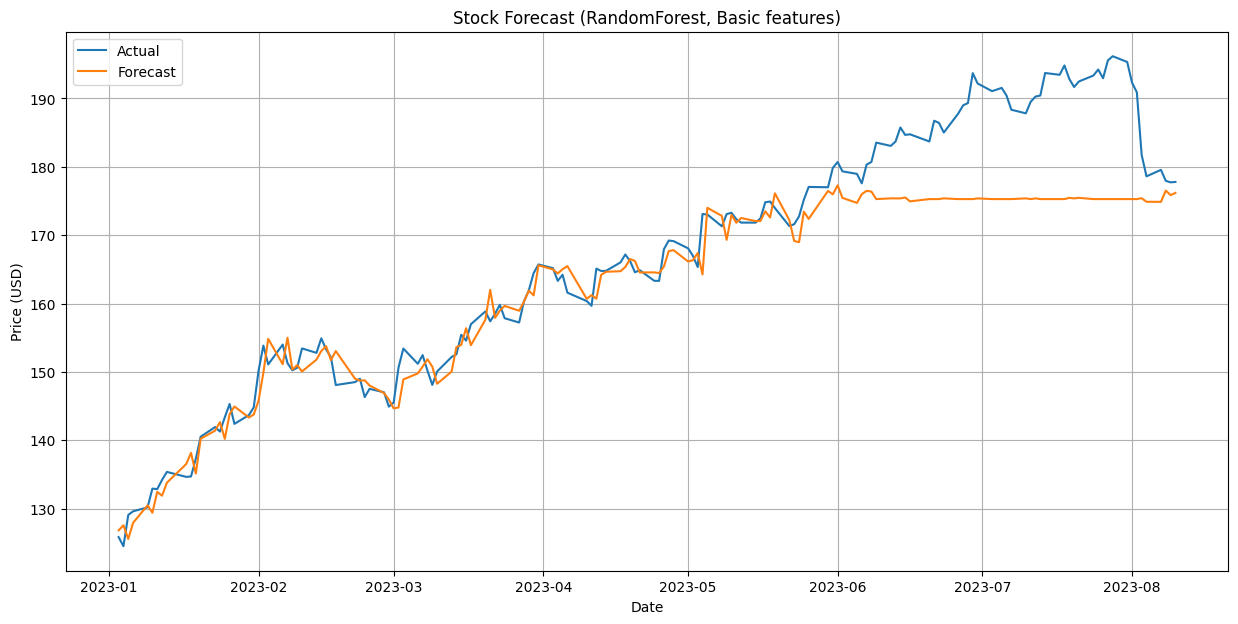

In [ ]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X_raw = df.iloc[:-1, :5]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train_raw = X_raw[X_raw.index.year < 2023].values
X_test_raw = X_raw[X_raw.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X_raw[X_raw.index.year == 2023].index

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(random_state=42, n_jobs=1)
rf.fit(X_train_raw, y_train)

# 모델을 사용하여 예측 수행
yhat = rf.predict(X_test_raw)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test_raw, y_test)

# 결과 출력
print(f'Features = {list(X_raw.columns)} \n')
print(f'MAE:           {mae}')
print(f'MSE:           {mse}')
print(f'R^2:           {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (RandomForest, Basic features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

KNN 모델을 사용해 예측 할 때보다 그래프 상에서는 loss값이 작아 보였지만, 실제 성능 지표는 좋지 않았다(MAE 기준). 후행예측을 하는 느낌이 있다.    특정시점부터 예측을 포기해버리는 모습은 같다.

#### With additional features
* 추가한 변수들: 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'

Columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

MAE:           5.487217284754704
MSE:           69.18508156536878
R^2:           0.7966142814088369


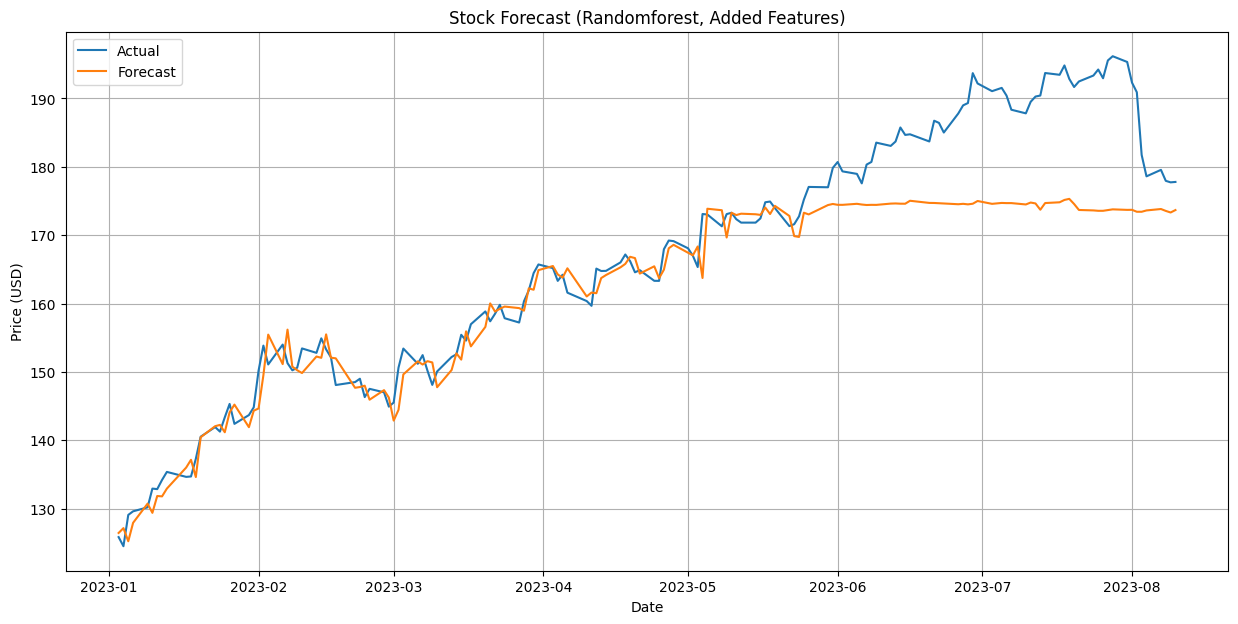

In [ ]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X[X.index.year == 2023].index

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 모델을 사용하여 예측 수행
yhat = rf.predict(X_test)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test, y_test)

# 결과 출력
print(f'Columns = {list(X.columns)} \n')
print(f'MAE:           {mae}')
print(f'MSE:           {mse}')
print(f'R^2:           {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (Randomforest, Added Features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

feature들을 추가한 결과, 오히려 성능지표는 좋지 않았다.

##### Hyperparameter tunning (GridSearchCV)
Model Hyperparameter tunning with features selected above

Columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

MAE:           5.4970817054326275
MSE:           69.71943390835487
R^2:           0.7950434277970448


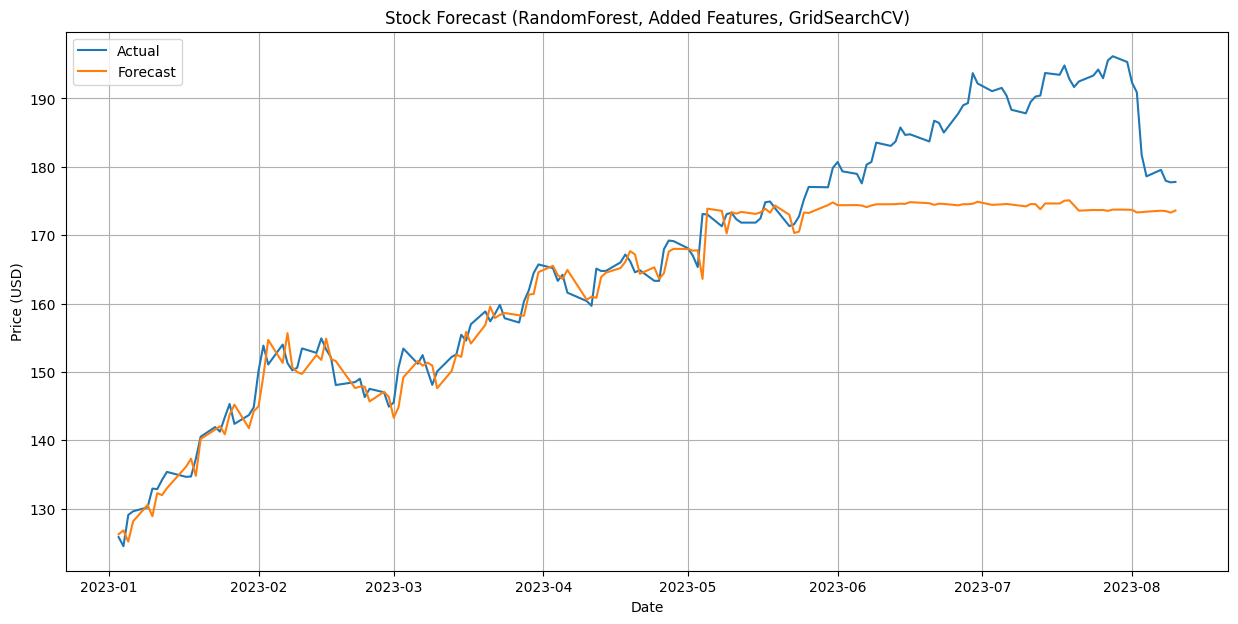

In [ ]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 랜덤 포레스트 모델 훈련 및 그리드 서치로 최적의 하이퍼파라미터 탐색
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 12, 14],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [6, 8, 10],
    "max_features": [1.0, "sqrt", "log2"],
    "bootstrap": [True, False],
}

rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터 저장
max_depth = grid_cv.best_params_['max_depth']
min_samples_leaf = grid_cv.best_params_['min_samples_leaf']
min_samples_split = grid_cv.best_params_['min_samples_split']
n_estimators = grid_cv.best_params_['n_estimators']

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 훈련
rf = RandomForestRegressor(
    random_state=42, n_estimators=n_estimators, max_depth=max_depth,
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split
)
rf.fit(X_train, y_train)

# 모델을 사용하여 예측 수행
yhat = rf.predict(X_test)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test, y_test)

# 결과 출력
print(f'Columns = {list(X.columns)} \n')
print(f'MAE:           {mae}')
print(f'MSE:           {mse}')
print(f'R^2:           {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (RandomForest, Added Features, GridSearchCV)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

최적의 하이퍼파라미터를 찾기 위해 GridSearchCV를 사용했지만, MAE값이 오히려 감소한 성능을 보인다.

##### K-fold Cross validation
* 특정시점부터 예측을 포기하는 경향이 Overfitting인한 것인지 확인하기 위해 K-fold Cross validation을 시행하였다.
* 단, 시계열 데이터의 특성 상 기존의 K-fold방식을 사용하면 test 데이터셋을  데이터의 순차적인 특성이 흐트러지는 문제가 발생한다.

In [ ]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023]
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')]
y_test = y[y.index.year == 2023][1:].values

tscv = TimeSeriesSplit(n_splits=5, test_size=100)

n = 0
for train_index, valid_index in tscv.split(X_train):
    X_train_split, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]


    # 랜덤 포레스트 모델 생성 및 훈련
    rf = RandomForestRegressor(
    random_state=42, bootstrap=True, max_depth=max_depth, max_features=1.0,
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators
)
    rf.fit(X_train_split, y_train_split)

    # 예측값 계산
    y_valid_hat = rf.predict(X_valid)
    print(f'Fold # {n+1}')
    print(f'Train_score: {rf.score(X_train_split, y_train_split)}')
    print(f'Valid_score: {rf.score(X_valid, y_valid)} \n')
    n += 1

yhat = rf.predict(X_test)
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test, y_test)

print(f'Columns = {list(X.columns)} \n')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {R2}')

Fold # 1
Train_score: 0.9997500592992785
Valid_score: 0.6474934740668237 

Fold # 2
Train_score: 0.9997800906541308
Valid_score: 0.07843451042995497 

Fold # 3
Train_score: 0.999823873288115
Valid_score: -2.185882790351506 

Fold # 4
Train_score: 0.9998309676073857
Valid_score: 0.9195010543300665 

Fold # 5
Train_score: 0.9998294281088036
Valid_score: 0.8892817693705111 

Columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

MAE: 5.370559010871324
MSE: 66.93863737530776
R^2: 0.803218229189672


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


모델의 Overfitting을 의심하고 Cross-validation을 시행한 결과,  각 fold간의 Train_score는 일정하게 유지되는 반면에, Valid_score는 변동이 심하다. <br>
따라서, 예상했던 것과 같이 Overfitting되었다고 판단된다. <br>


GridSearchCV를 통해서 최적의 성능을 보이는 하이퍼파라미터값을 알아내기 위해, RandomForest의 과적합에 영향을 줄 수 있는 하이퍼파라미터들도 포함시켰지만,  최적의 하이퍼파라미터 조합으로도 RandomForest의 과적합을 피할 수 없었다. <br>
추후에, 다수의 RandomForest모델을 앙상블 모델로 묶어서 과적합을 방지하는 방법을 모색해 볼 수 있겠다. <br>
또는, 현재 Dataset은 20년치이지만 이보다 더 긴 기간의 Dataset을 사용하고 좀 더 다양한 feature들을 추가하는 것도 방법이 될 수 있을 것이라 생각한다.

랜덤성이 너무 짙고 외부적인 요인들이 많은 주가를 에측할 때 학습시킨 Data와 근접한 날짜의 예측은 정확도가 높아 보이지만, 점점 정확도가 떨어지다가 예측을 포기해버리는 것으로 보인다. <br> 가장 최신의 Data로 모델을 주기적으로 학습시켜 Update된 모델로 주가를 예측해야 성능이 보장될 수 있을 것이다.

---

# Deep Learning

### Dataset

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/AI_2023/project_2_ML_DL_Time_Series_Forcasting"

/content/drive/MyDrive/Colab Notebooks/AI_2023/project_2_ML_DL_Time_Series_Forcasting


In [ ]:
# Download historical stock data of Apple (AAPL) using yfinance (yf) library
# DataFrame "last_update": 2003-08-05 ~ today (2023-08-06)
last_update = yf.download('AAPL',
                   start = '2003-08-05',
                   end = '2023-08-04',
                   progress = False)

In [ ]:
# DataFrame "df":
df = last_update.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5034 entries, 2003-08-05 to 2023-08-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5034 non-null   float64
 1   High       5034 non-null   float64
 2   Low        5034 non-null   float64
 3   Close      5034 non-null   float64
 4   Adj Close  5034 non-null   float64
 5   Volume     5034 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.3 KB


In [ ]:
# Making sure the DataFrame is in ascending order based on the "Date" column
df = df.sort_values(by='Date', ascending=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-08-05,0.381250,0.382143,0.358929,0.363929,0.308902,249440800
2003-08-06,0.358214,0.360179,0.348214,0.350536,0.297534,245464800
2003-08-07,0.352321,0.358750,0.346786,0.355893,0.302081,174378400
2003-08-08,0.359107,0.359464,0.350000,0.350714,0.297685,137659200
2003-08-11,0.353929,0.355893,0.348393,0.351071,0.297988,137228000
...,...,...,...,...,...,...
2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400
2023-07-31,196.059998,196.490005,195.259995,196.449997,196.185074,38824100
2023-08-01,196.240005,196.729996,195.279999,195.610001,195.346207,35175100


#### Feature engineering & Preprocessing

#### Feature removal

In [ ]:
# Adj is dictated by company policy which is relatively random compared to other variables
# and thus would not be suitable for this exploratory data analysis
df = df.drop(columns=['Adj Close'])

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

#### Target (X) and features (y)
* The target (y) is the close price of tomorrow.
* The features (X) includes 5 variables: "Open", "High",	"Low", "Close",	and "Volume".

In [ ]:
X = df.iloc[:-1]
y = df.iloc[1:,3]

#### Train-test split
* `train` data: Up to 2022-12-31
* `test` data: Starting from 2023-01-01

In [ ]:
X_train_data = X[X.index.year < 2023]
X_test_data = X[X.index.year == 2023]
y_train_data = y[y.index <= np.datetime64('2023-01-03')]    # 2023-01-03: First market day if 2023; Tomorrow's Close price of the last day or 2022
y_test_data = y[y.index.year == 2023][1:]
n_data = len(y)
print(f"X: \ntrain shape: {X_train_data.shape},  {int(len(X_train_data)/n_data *100)} % \ntest shape : {X_test_data.shape},  {int(len(X_test_data)/n_data *100)} %")
print(f"y: \ntrain shape: {y_train_data.shape},  {int(len(y_train_data)/n_data *100)} % \ntest shape : {y_test_data.shape},  {int(len(y_test_data)/n_data *100)} %")

X: 
train shape: (4887, 5),  97 % 
test shape : (146, 5),  2 %
y: 
train shape: (4887,),  97 % 
test shape : (146,),  2 %


In [ ]:
# Without index
X_train = X_train_data.values
X_test = X_test_data.values
y_train = y_train_data.values
y_test = y_test_data.values

The typical train-test split ratio is 80:20. However, since our aim is to predict tomorrow's data, we strive to train our model with the most recent historical data available. Therefore, we've opted not to adhere strictly to the 80:20 ratio, as it would result in using significantly older data for training.

On the other hand, we also want to avoid training the model with excessively recent data, which could lead it to simply output today's price or a value very close to it when predicting tomorrow's price. Although such a model might yield favorable metrics like MAE or RMSE, it would lack the true forecasting capability we're after.

To strike a balance, we've adjusted the train-test split. Our model will be trained using historical data spanning approximately up to the past seven months. We believe this ratio offers a favorable compromise that enables the model to learn from relevant historical patterns without succumbing to overfitting tendencies.

#### Standard scaling of features
* We will scale features (X) only and not the target variable (y).
* First, a StandardScaler will be fitted to X_train data and transform it.
* Then, X_test data will be transformed using the scaler fitted to X_train. This will ensure the test data do be scaled based on the mean and standard deviation of the train data.
* This is because the test data aims to replace the unseen future data, whose distribution remains unknown.

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
print("== X_train Statistics ==")
print(pd.DataFrame(X_train, columns=df.columns).describe()); print()
print("== X_test Statistics ==")
print(pd.DataFrame(X_test, columns=df.columns).describe())

== X_train Statistics ==
              Open          High           Low         Close        Volume
count  4887.000000  4.887000e+03  4.887000e+03  4.887000e+03  4.887000e+03
mean      0.000000  4.652623e-17 -9.305246e-17  9.305246e-17  9.305246e-17
std       1.000102  1.000102e+00  1.000102e+00  1.000102e+00  1.000102e+00
min      -0.780227 -7.793872e-01 -7.810092e-01 -7.801165e-01 -9.772448e-01
25%      -0.680638 -6.795747e-01 -6.824395e-01 -6.806095e-01 -7.433213e-01
50%      -0.362747 -3.637425e-01 -3.626842e-01 -3.641681e-01 -3.262816e-01
75%       0.159720  1.573893e-01  1.629736e-01  1.584842e-01  4.338559e-01
max       3.280838  3.238747e+00  3.250806e+00  3.264788e+00  7.459611e+00

== X_test Statistics ==
             Open        High         Low       Close      Volume
count  146.000000  146.000000  146.000000  146.000000  146.000000
mean     2.893775    2.886938    2.911706    2.900999   -0.912215
std      0.422159    0.411706    0.429126    0.418199    0.045969
min      2.

(Note)

X_train: mean ≈ 0, std ≈ 1

X_test : mean ≈ 3, std ≈ 0.4

#### K-fold cross validation for time series data

* Traditional cross-validation techniques, e.g. k-fold cross-valddation, might not be appropriate for time sereis data because they can introduce data leakage where information from the future inadverently used to predict the past.
* TimeSeriesSplit splits splits a dataset so that the training data comes before the validation data in terms of time, enabling the cross-validation in time-sereis analysis without compromising the chronological characteristics of data.

TimeSeriesSplit module introduction

In [ ]:
X_train.shape, X_test.shape

((4887, 5), (146, 5))

In [ ]:
# How the TimeSeriesSplit module performs split
k = 3
tscv = TimeSeriesSplit(n_splits=k)

for train_index, valid_index in tscv.split(X_train):
    X_train_, y_train_ = X_train[train_index], y_train[train_index]
    X_valid, y_valid = X_train[valid_index], y_train[valid_index]

# Indices of each folds of TimeSeriesSplit
for i, (train_index, valid_index) in enumerate(tscv.split(X_train)):
    print(f"Fold#{i+1}:")
    print("train_index:", train_index)
    print(f"TRAIN: {train_index[0]} ~ {train_index[-1]}" )
    print(f"Valid: {valid_index[0]} ~ {valid_index[-1]} len= \n")

Fold#1:
train_index: [   0    1    2 ... 1221 1222 1223]
TRAIN: 0 ~ 1223
Valid: 1224 ~ 2444 len= 

Fold#2:
train_index: [   0    1    2 ... 2442 2443 2444]
TRAIN: 0 ~ 2444
Valid: 2445 ~ 3665 len= 

Fold#3:
train_index: [   0    1    2 ... 3663 3664 3665]
TRAIN: 0 ~ 3665
Valid: 3666 ~ 4886 len= 



The manual splitting method inspired by TimeSeriesSplit module

* When using the original method the LSTM model performance was not good.

* It is concluded that the Fold#1 and and Fold#2 in particular are too far away from the test dataset we are predicting.

* Thus instead of splitting the train dataset using the TimeSeriesSplit, it will be manually splitted for this project as follows:
```
num_test = len(X_test)
n_split = 3
for i in range(n_split):
    val_end_idx = len(X_train)
    val_start_idx = val_end_idx - num_test
    if i == 0:
        train_start_idx = 0
    else:
        train_start_idx = num_test*(i)-1        
```

#### make_sequences

In [ ]:
def make_sequenced_train_test(sequence_length, X_train, y_train, X_test, y_test):
    # Define the number of time steps to look back (sequence length)
    # Sequence_length: the No. of consecutive data points included in each input sequence

    # Create sequences of historical data and corresponding target values
    X_train_ = []
    y_train_ = []
    X_test_ = []
    y_test_ = []
    for i in range(len(y_train) - sequence_length):     # Using sequence_lenth-many data (10 days), predict the next day's close price (one-day look ahead)
        X_train_.append(np.array(X_train[i:i+sequence_length]))  # sequence (seq): consecutive 10 days
        y_train_.append(np.array(y_train[i+sequence_length]))    # Predict the close price of the day after the last day of the seq

    for i in range(len(y_test) - sequence_length):
        X_test_.append(np.array(X_test[i:i+sequence_length]))
        y_test_.append(np.array(y_test[i+sequence_length]))

    X_train_ = np.array(X_train_); y_train_ = np.array(y_train_)
    X_test_ = np.array(X_test_); y_test_ = np.array(y_test_)
    return X_train_, y_train_, X_test_, y_test_

In [ ]:
X_train_10, y_train_10, X_test_10, y_test_10 = make_sequenced_train_test(10, X_train, y_train, X_test, y_test)
print("Not sequenced:\t", "TRAIN", X_train.shape, y_train.shape, "\tTEST", X_test.shape, y_test.shape)          # (4887, 5) (4887,) (146, 5) (146,)
print("Sequenced:\t", "TRAIN", X_train_10.shape, y_train_10.shape, "\tTEST", X_test_10.shape, y_test_10.shape)  # (4877, 10, 5) (4877,) (136, 10, 5) (136,)

Not sequenced:	 TRAIN (4887, 5) (4887,) 	TEST (146, 5) (146,)
Sequenced:	 TRAIN (4877, 10, 5) (4877,) 	TEST (136, 10, 5) (136,)


In [ ]:
4887+146, 4877+136

(5033, 5013)

### LSTM

#### Simple model - Regression

##### Model training

In [ ]:
def build_simple_lstm_model(sequence_length, num_features):
    num_features = len(df.columns)

    # Build the LSTM model
    lstm_layers = 1
    lstm_units = 50    # 50
    lambda_l2 = None
    lr_optimizer = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_optimizer)
    dropout_rate = None
    tf.random.set_seed(42)

    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(sequence_length, num_features)))   # Add an LSTM layer with 50 LSTM units (=neurons); input_shape=(10, 5) meaning 10 records each with 5 features
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=my_metrics)
    return model

In [ ]:
# From model building to model training with cross-validation
num_train = len(X_train_10) # 4877
num_test = len(X_test_10)   # 136

n_split = 3

fold_num = 1
histories = []
loss_per_fold, mae_per_fold, mse_per_fold, rmse_per_fold = [], [], [], []
for i in range(n_split, 0, -1):
    # print(i+1)
    val_end_idx = len(X_train_10)
    val_start_idx = val_end_idx - num_test
    if i == 0:
        train_start_idx = 0
    else:
        train_start_idx = num_test*(i)-1

    X_train_10_, y_train_10_ = X_train_10[train_start_idx:val_start_idx], y_train_10[train_start_idx:val_start_idx]
    X_val_10, y_val_10 = X_train_10[val_start_idx:val_end_idx], y_train_10[val_start_idx:val_end_idx]

    print(f"=================================== Fold#{fold_num} ===================================")
    print("train_start_idx", train_start_idx, "-->", "val_start_idx", val_start_idx, "-->", "val_end_idx", val_end_idx)
    print()
    print("train_:\t", X_train_10_.shape, y_train_10_.shape)
    print("val:\t", X_val_10.shape, y_val_10.shape)
    print("test:\t", X_test_10.shape, y_test_10.shape, "\n")

    # Build simple LSTM model
    sequence_length = 10
    num_features = len(df.columns)
    model = build_simple_lstm_model(sequence_length, num_features)

    # Fit the model with train-val data
    epochs = 100     # 100
    batch_size = 32  # 32
    tf.random.set_seed(42)
    history = model.fit(X_train_10_, y_train_10_, validation_data=(X_val_10, y_val_10), epochs=epochs, batch_size=batch_size, verbose=1)
    histories.append(history)

    # Increase fold num
    fold_num += 1

=================================== Fold#1 ===================================
train_start_idx 407 --> val_start_idx 4741 --> val_end_idx 4877

train_:	 (4334, 10, 5) (4334,)
val:	 (136, 10, 5) (136,)
test:	 (136, 10, 5) (136,) 

Epoch 1/100
136/136 [==============================] - 4s 12ms/step - loss: 2519.7908 - mean_absolute_error: 30.6091 - mean_squared_error: 2519.7908 - root_mean_squared_error: 50.1975 - val_loss: 18192.5664 - val_mean_absolute_error: 134.4404 - val_mean_squared_error: 18192.5664 - val_root_mean_squared_error: 134.8798
Epoch 2/100
136/136 [==============================] - 1s 8ms/step - loss: 1978.5725 - mean_absolute_error: 22.8396 - mean_squared_error: 1978.5725 - root_mean_squared_error: 44.4811 - val_loss: 16331.3838 - val_mean_absolute_error: 127.3302 - val_mean_squared_error: 16331.3838 - val_root_mean_squared_error: 127.7943
Epoch 3/100
136/136 [==============================] - 1s 8ms/step - loss: 1711.6847 - mean_absolute_error: 19.2935 - mean_squared_

###### Training results

In [ ]:
# conditions used to set the simple lstm model function
lstm_layers = 1
lstm_units = 50
lambda_l2 = None
lr_optimizer = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_optimizer)
dropout_rate = None
batch_size = 32

In [ ]:
# Plot both the training and test loss curves
def plot_loss_func_curve(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

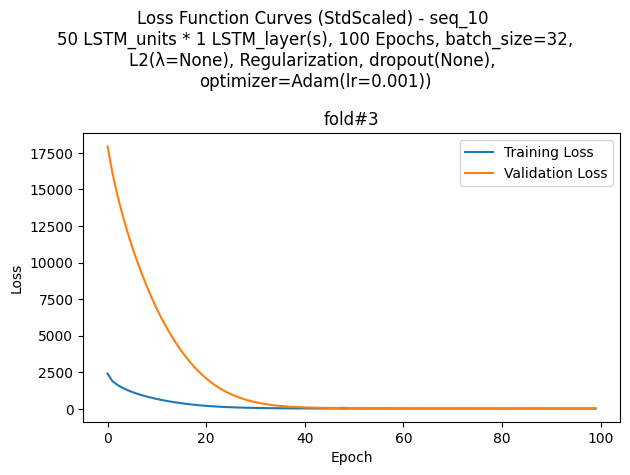

In [ ]:
plt.subplot(1,1,1)
plot_loss_func_curve(histories[i])
plt.title(f"fold#{fold_num-1}")
plt.suptitle(f'Loss Function Curves (StdScaled) - seq_10 \n{lstm_units} LSTM_units * {lstm_layers} LSTM_layer(s), {epochs} Epochs, batch_size={batch_size},\nL2(λ={lambda_l2}), Regularization, dropout({dropout_rate}), \noptimizer={optimizer.name}(lr={lr_optimizer}))')
plt.tight_layout()
plt.show()

(Note)

The loss function curves of the training and validation loss indicates that the two losses decreases steeply from 0 to 40 epochs and stabilize from there on.

Because the scale range of the loss is big (0 to 17500), it is not clear on the figure whether the fluctuation of loss occurs after the epoch 40 or whether the decrease in the loss is meaningful in after the epoch 40.

However, in the printed outputs of the training/optimizing process from the previous code cell, it is demonstrated that there is a steady decrease in the loss with little fluctuations, although the reduction is relatively modest.

###### Prediction results

In [ ]:
# Make predictions
tf.random.set_seed(42)
y_pred_10 = model.predict(X_test_10)

5/5 [==============================] - 1s 4ms/step


In [ ]:
# Calculate RMSE
def calculate_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test.flatten(), y_pred.flatten())
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    ood_score = metrics.explained_variance_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): \t {mae}")
    print(f"Mean Squared Error (MSE):\t {rmse}")
    print(f"Root Mean Squared Error (RMSE):  {rmse}")
    print(f"R-squared (R^2): \t\t {r2}")
    print(f"Out-of-Distribution Score (OOD): {ood_score}")

print("== Model's prediction evaluation on the test set ==")
calculate_metrics(y_test_10, y_pred_10)

== Model's prediction evaluation on the test set ==
Mean Absolute Error (MAE): 	 4.841352238374598
Mean Squared Error (MSE):	 6.453944945968897
Root Mean Squared Error (RMSE):  6.453944945968897
R-squared (R^2): 		 0.8473123882703346
Out-of-Distribution Score (OOD): 0.88408569815723


In [ ]:
def plot_actual_vs_pred(y_test_date_index, y_test, y_pred):
    # Plot actual vs. predicted stock prices
    plt.plot(y_test_date_index, y_test, label='Actual')
    plt.plot(y_test_date_index, y_pred, label='Predicted')
    plt.ylabel("Close ($)")

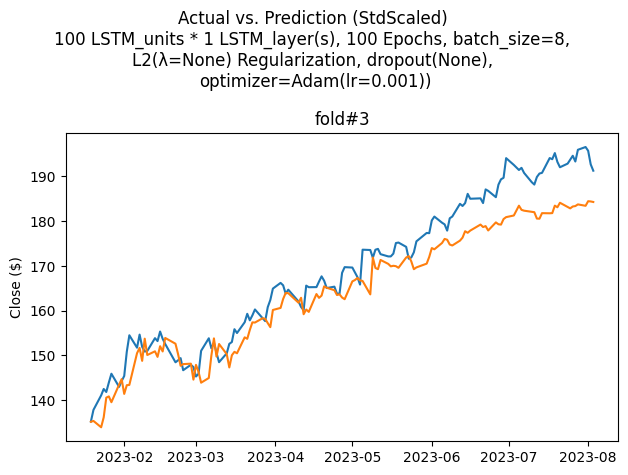

In [ ]:
y_test_date_index = y_test_data.index[sequence_length:]
plt.subplot(1,1,1)
plot_actual_vs_pred(y_test_date_index, y_test_10, y_pred_10)
plt.title("fold#3")
plt.suptitle(f'Actual vs. Prediction (StdScaled) \n{lstm_units} LSTM_units * {lstm_layers} LSTM_layer(s), {epochs} Epochs, batch_size={batch_size}, \nL2(λ={lambda_l2}) Regularization, dropout({dropout_rate}), \noptimizer={optimizer.name}(lr={lr_optimizer}))')
plt.tight_layout()
plt.show()

(Note)
* Jan 2023 ~ Jun 2023
    * The former part of the test dataset
    * MAE is low (less than 3)--> relatively good predictions
* Jul 2023 ~
    * The latter part of the test dataset
    * MAE is high --> relatively bad predictions

* Thus, the most basic model comprising a simgle layer of LSTM with 50 LSTM cells appears to underfit, particularly during the latter segment of the test dataset. In other words, the model's predictive performance diminishes as the day of prediction day moves further away from the last date of the data on which the model was trained, which suggests that the model is underfit and the tuning of the hyperparameters is needes.
* Hyperparameters to tune
    * The model is underfit
        * --> The effect of regularizations and adding dropout will not be tested
        * --> The effects of adding more LSTM units and or adding another layer of LSTM units will be tested to see if more complex model enables the model to fit better
        * --> Various batch_sizes will be testes to assess their impact on the model's convergence in the optimization process and on the performance.

##### Hyperparameter tuning

* LSTM units per layer <-- More complex model
    * Tested 50, 100, 200 units
    * When more LSTM units were added,
        1. it resulted in a slight performance improvement from 4.84 (50 units) to 4.45 (100 units) --> 4.45 (MAE); but it declined to 4.89 when 200 units were used (MAE),
        2. the loss curve stabilized earlier,
        3. the time needed to finish increased

* --> The best combination found so far is
    * 100 LSTM units / 1 LSTM layer * 1 LSTM layer.
* --> When LSTM units are 100, it may not be necessary to increase epoch to 100.

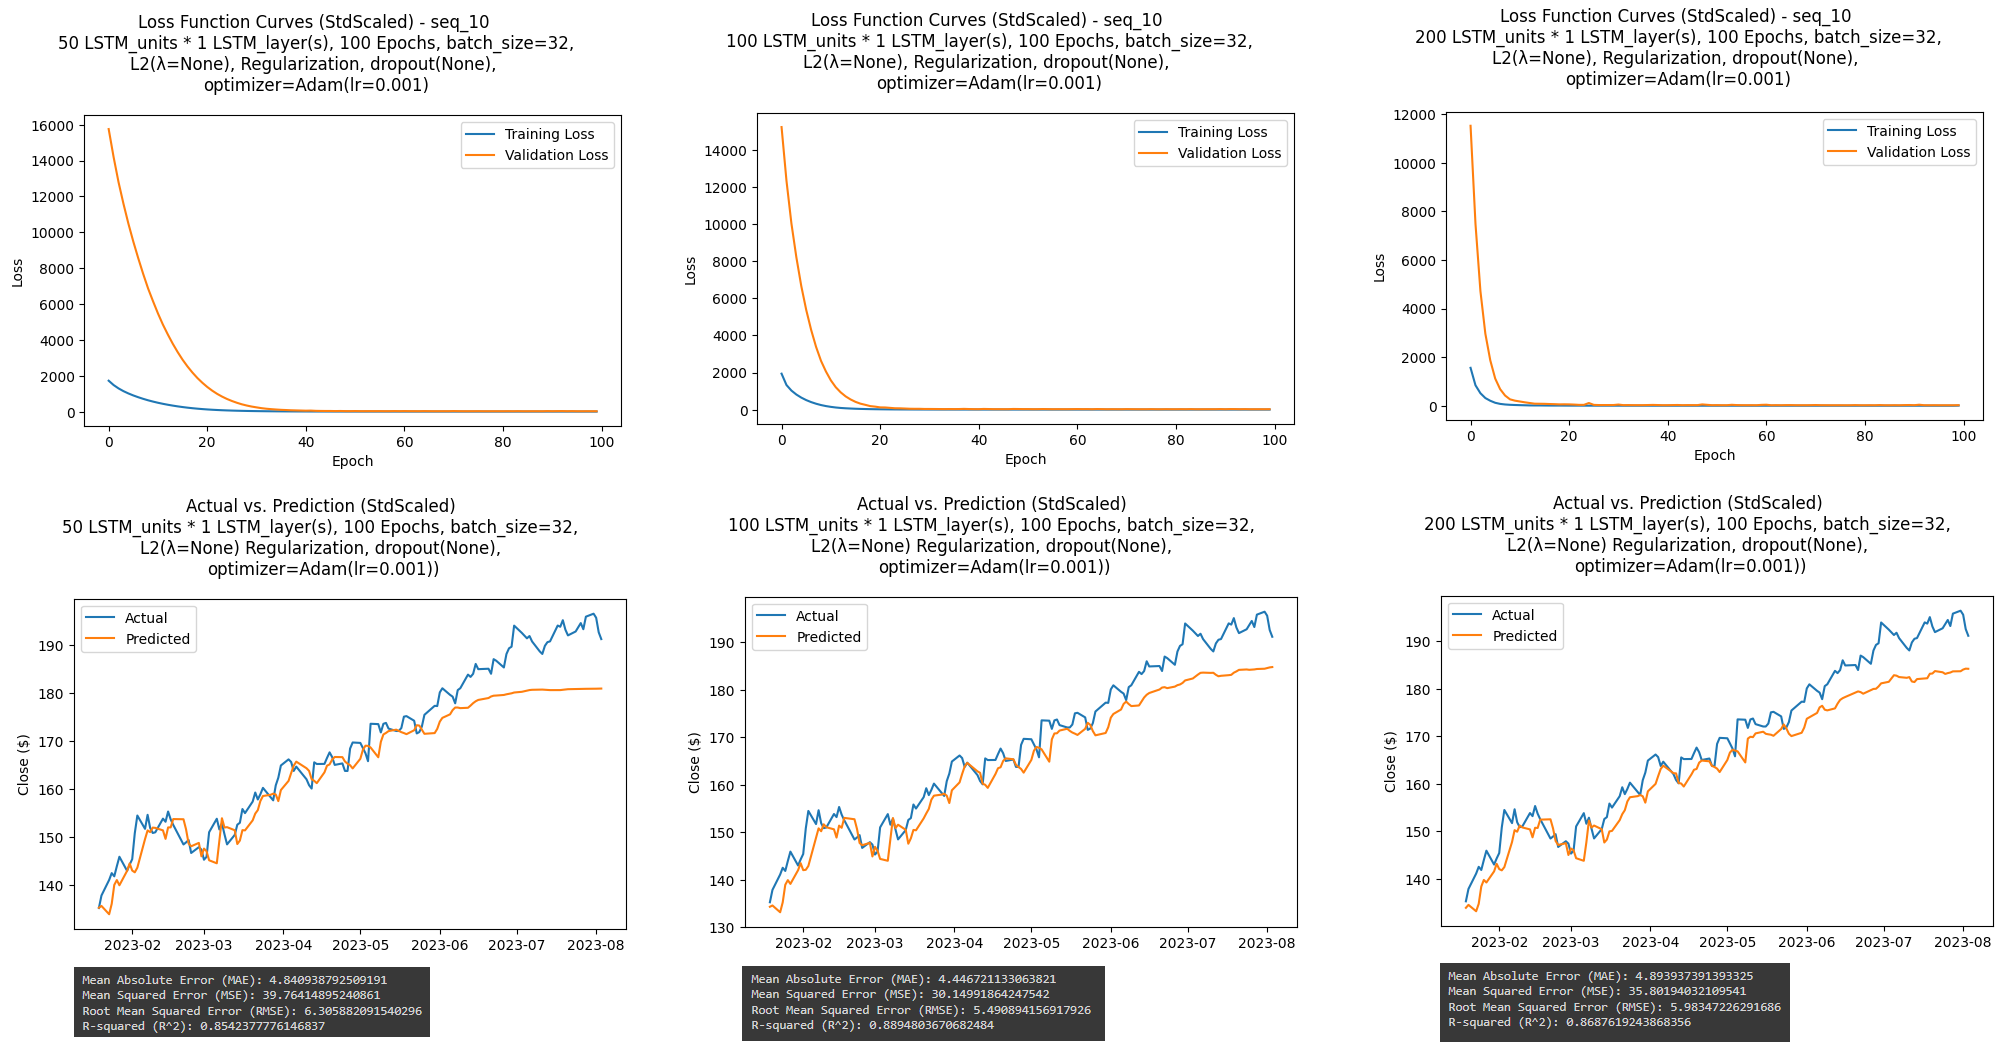

* Stacking another layer <-- More complex model
    * When 2 layers of 50-unit LSTM layers were stacked,
        1. it resulted in a performance decline from 4.84 to 5.98 (MAE),
        2. the loss curve stabilized at a similar time
        3. the time needed to finish increased even greater.
* --> The best combination found so far is still
    * 100 LSTM units / 1 LSTM layer * 1 LSTM layer.

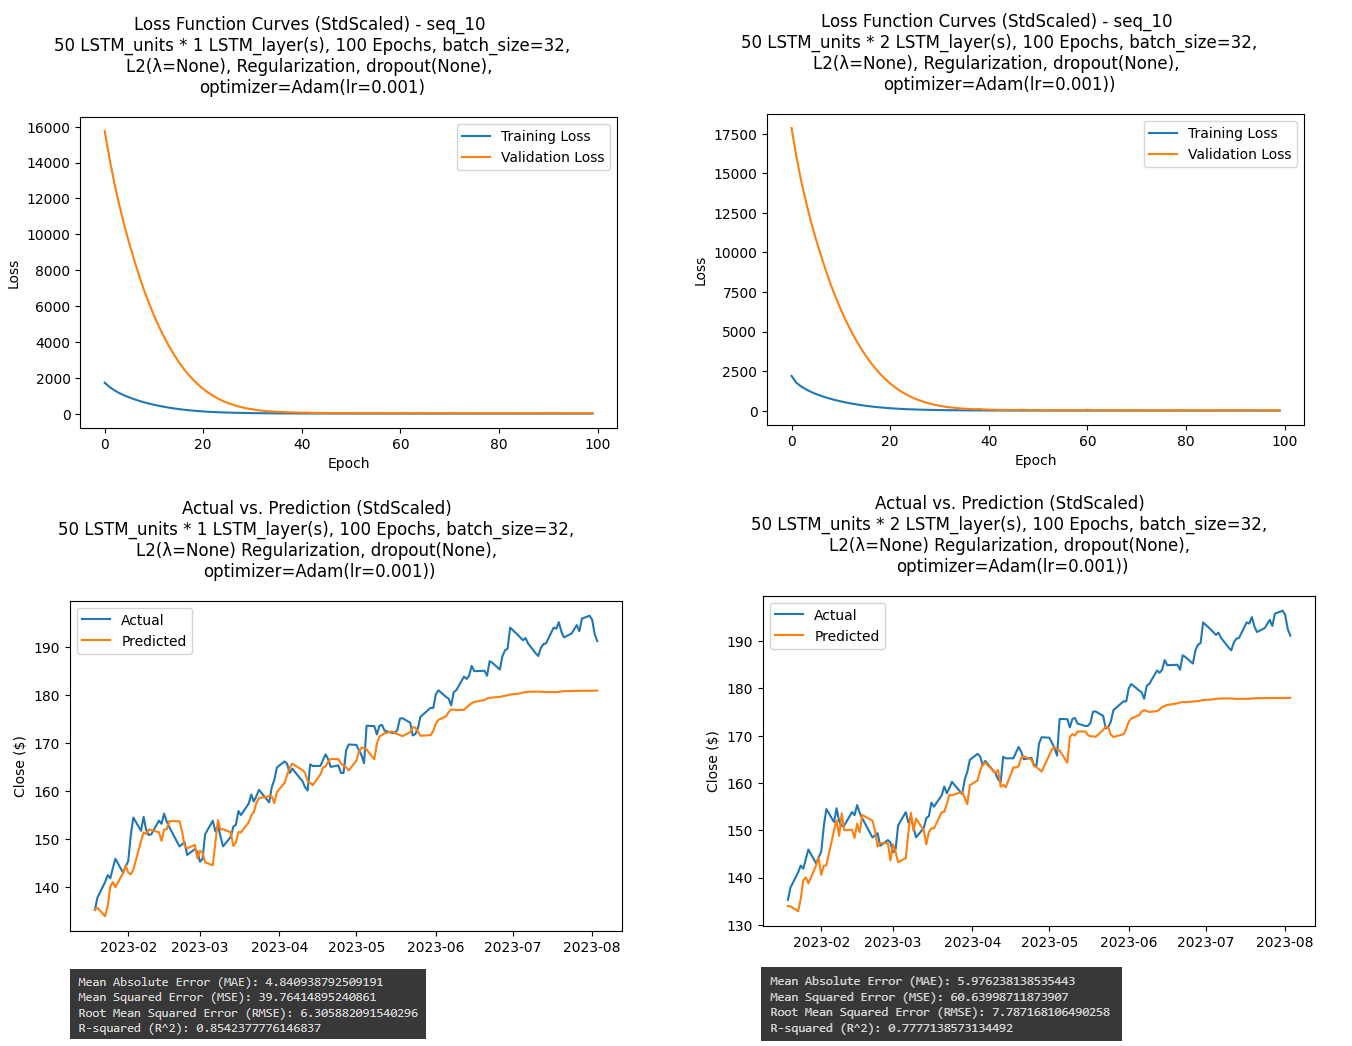

* Batch size
    * Tested sizes: 8, 16, 32, 64
    * Expectation
        * Bigger batch --> Faster convergence and better performance
    * Results
        * The smaller the batch size,
            1. the better the performance was,
            2. the earlier the training and validation loss stabilized,
            3. and the smaller the std was between fold.
        * --> this is contrary to the common effects of smaller batch size
        * --> A potential reason could be due to the smaller batch improving the model performance by facilitating the model's escape from the local minima.

* -->  The best batch_size so far: 8
* -->  At batch_size=8, we may not need to extend the epoch as many as 100 any more.

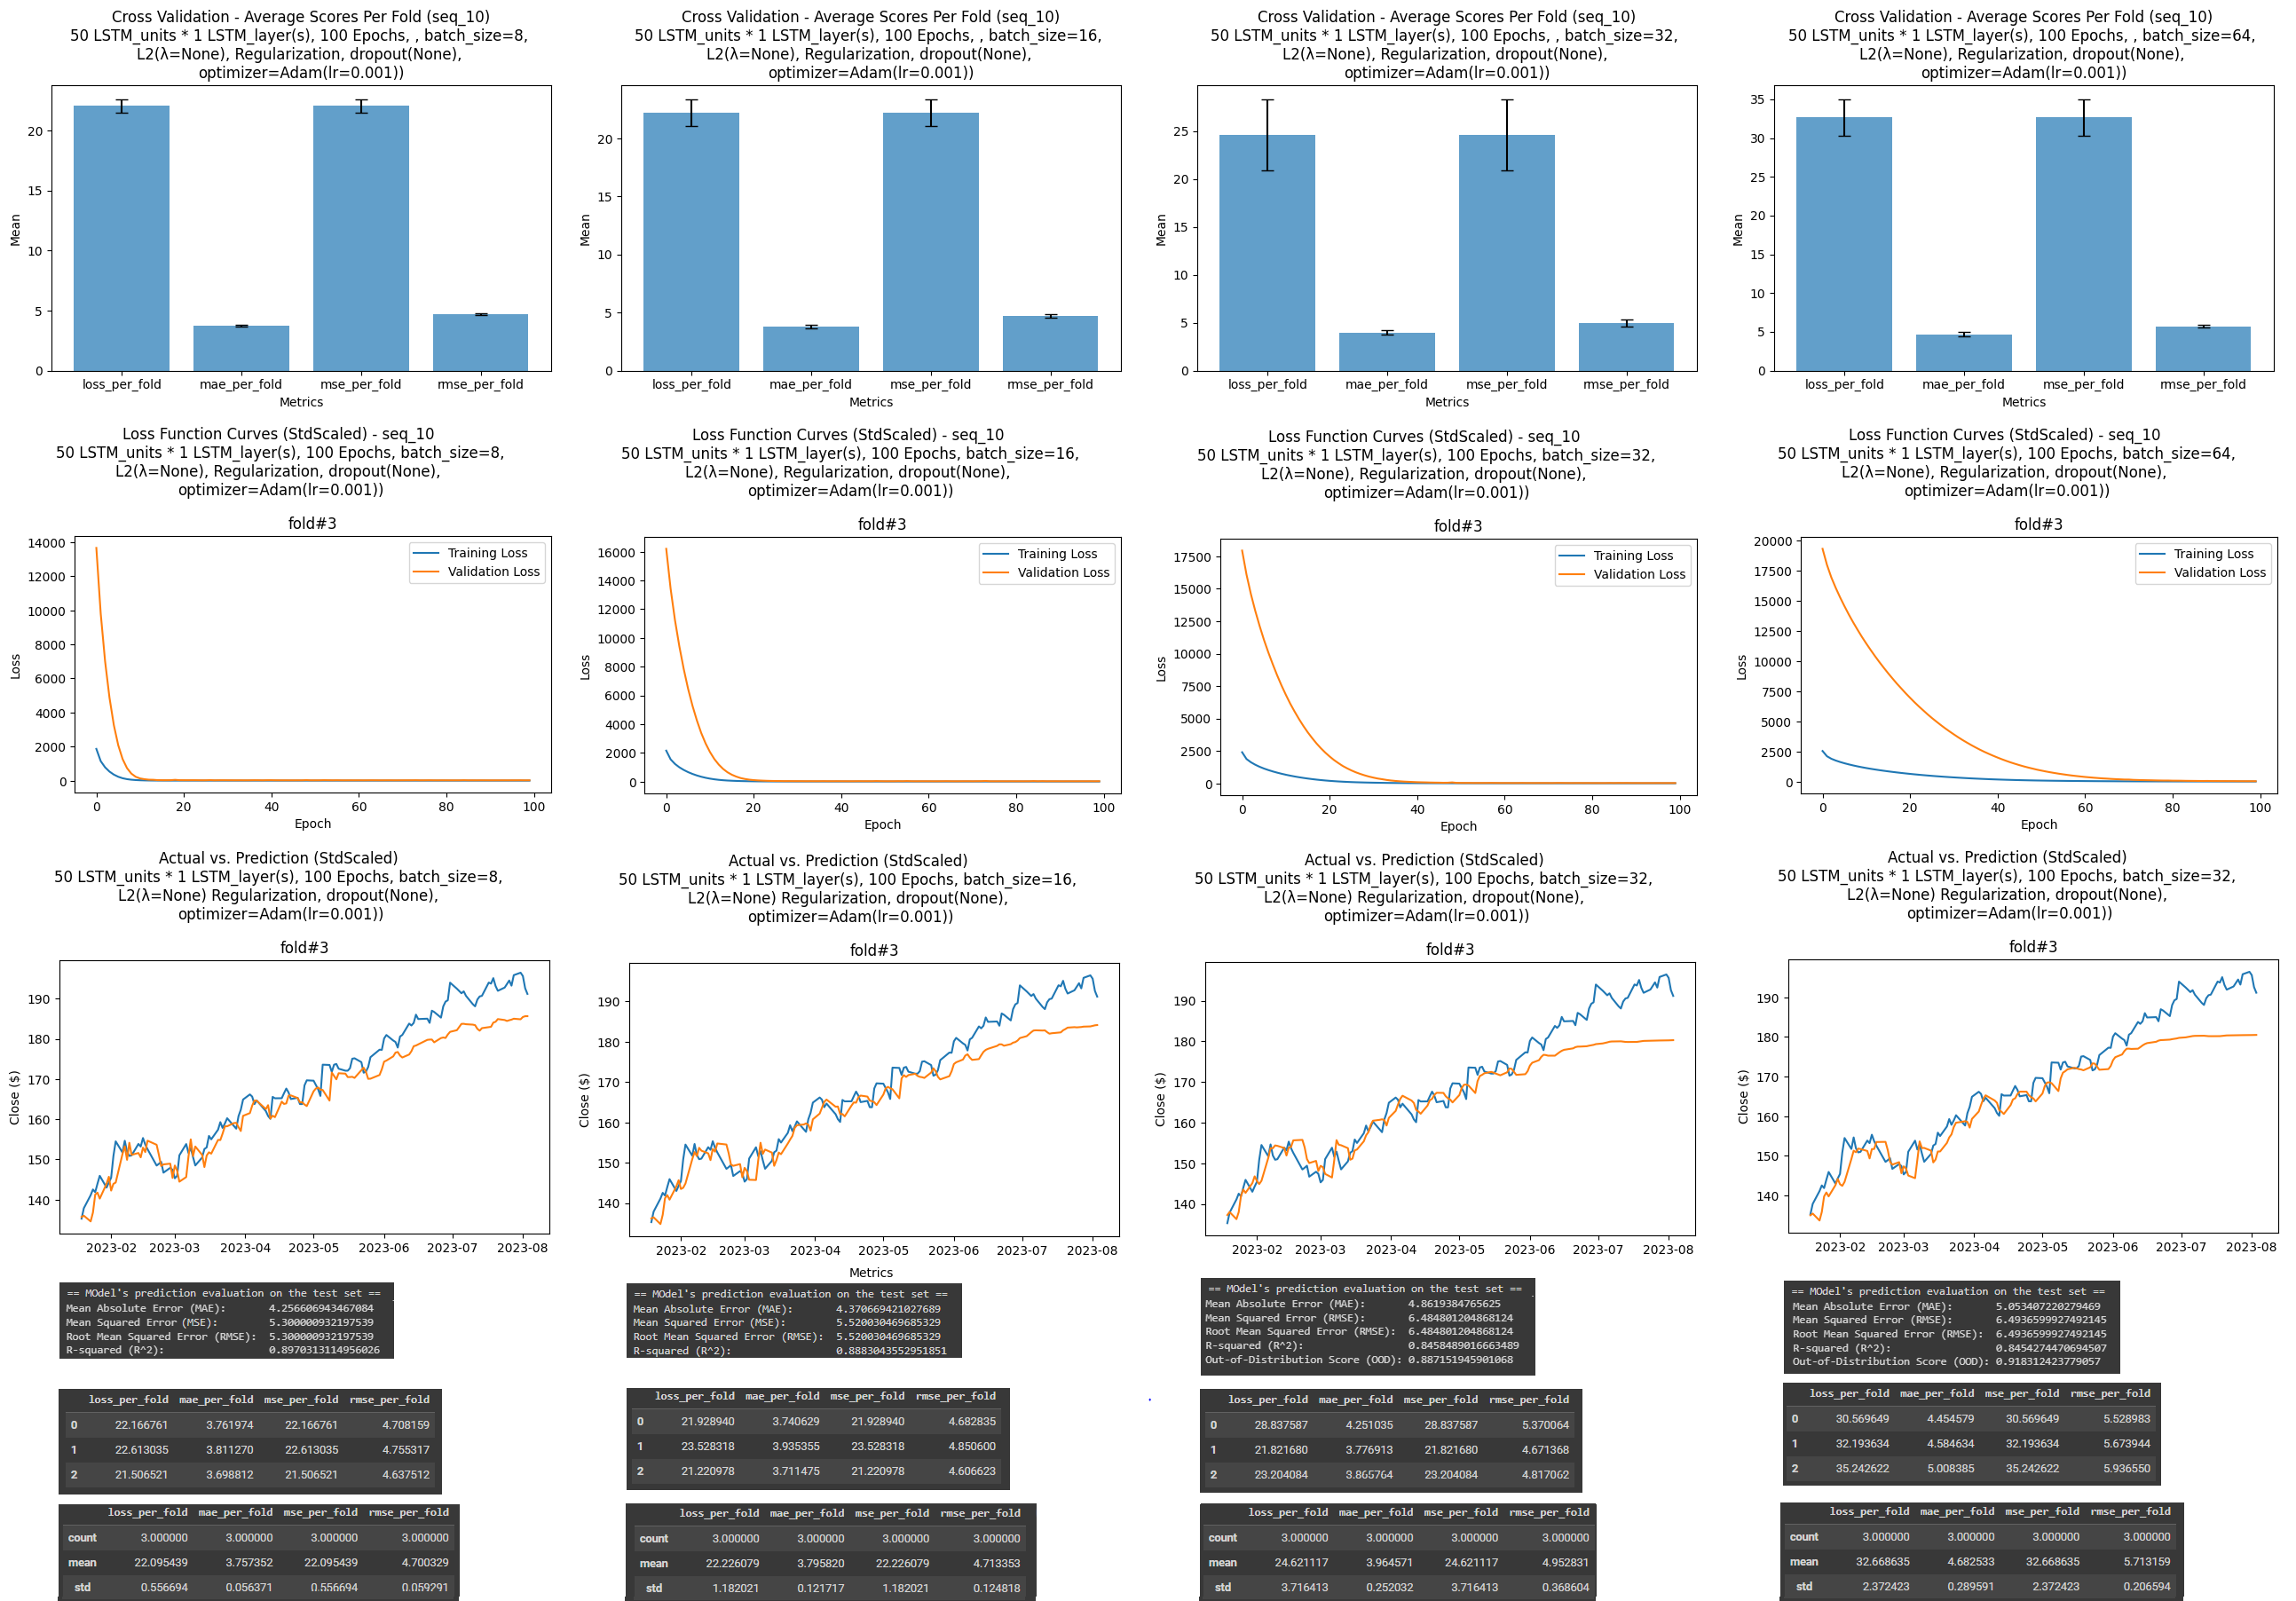

The figure below shows the comparison of the control model to the new model tested:
* The new model to be tested
    * 1 lstm_layer
    * 100 lstm_units per layer
    * batch_size 8
    * 100 and 40 epochs
* The control model
    * 1 lstm_layer
    * 50 lstm_units per layer
    * batch_size 8
    * 100 epochs

* Expectations
    * Compared to the control model, the new models are expected to
        1. demonstrate better performance in the new model
            * Of the new models, epoch 40 expected to performs similar to epoch 100
        2. stabilize the loss function curves earlier and thus requires fewer epochs needed to reach good performance
        3. take longer to train one epoch
* The results
    * Compared to the control model,
        1. the new models' performance declined from  4.26 to 4.85 (MAE)
            * The new model with epoch 40 performed similar to epoch 100 (both 4.85)
        2. the new model's loss curve stabilized earlier than that of the control model
        3. the new model took approx. twice longer to finish one epoch (12 sec compared to 6 sec)

* Thus, so far the hyperparameter combinations of the new model tested is not better in performance.
* --> Even if a certain batch_size performs better in a model with specific LSTM units, it does not guarantee better performance for a model with the different number of LSTM units.
* --> The hyperparameter combination of the best model so far :
    * 50 LSTM Units / LSTM layer * 1 LSTM layer
    * batch_size = 8
    * 40 ~ 100 epochs
* Next step :
    * Since the best model found shows stabilization of loss curves before the training reaches 20 epochs, it may be efficient to stop training earlier than epoch 100.
    * --> Early stopping method may aid deciding when to stop.


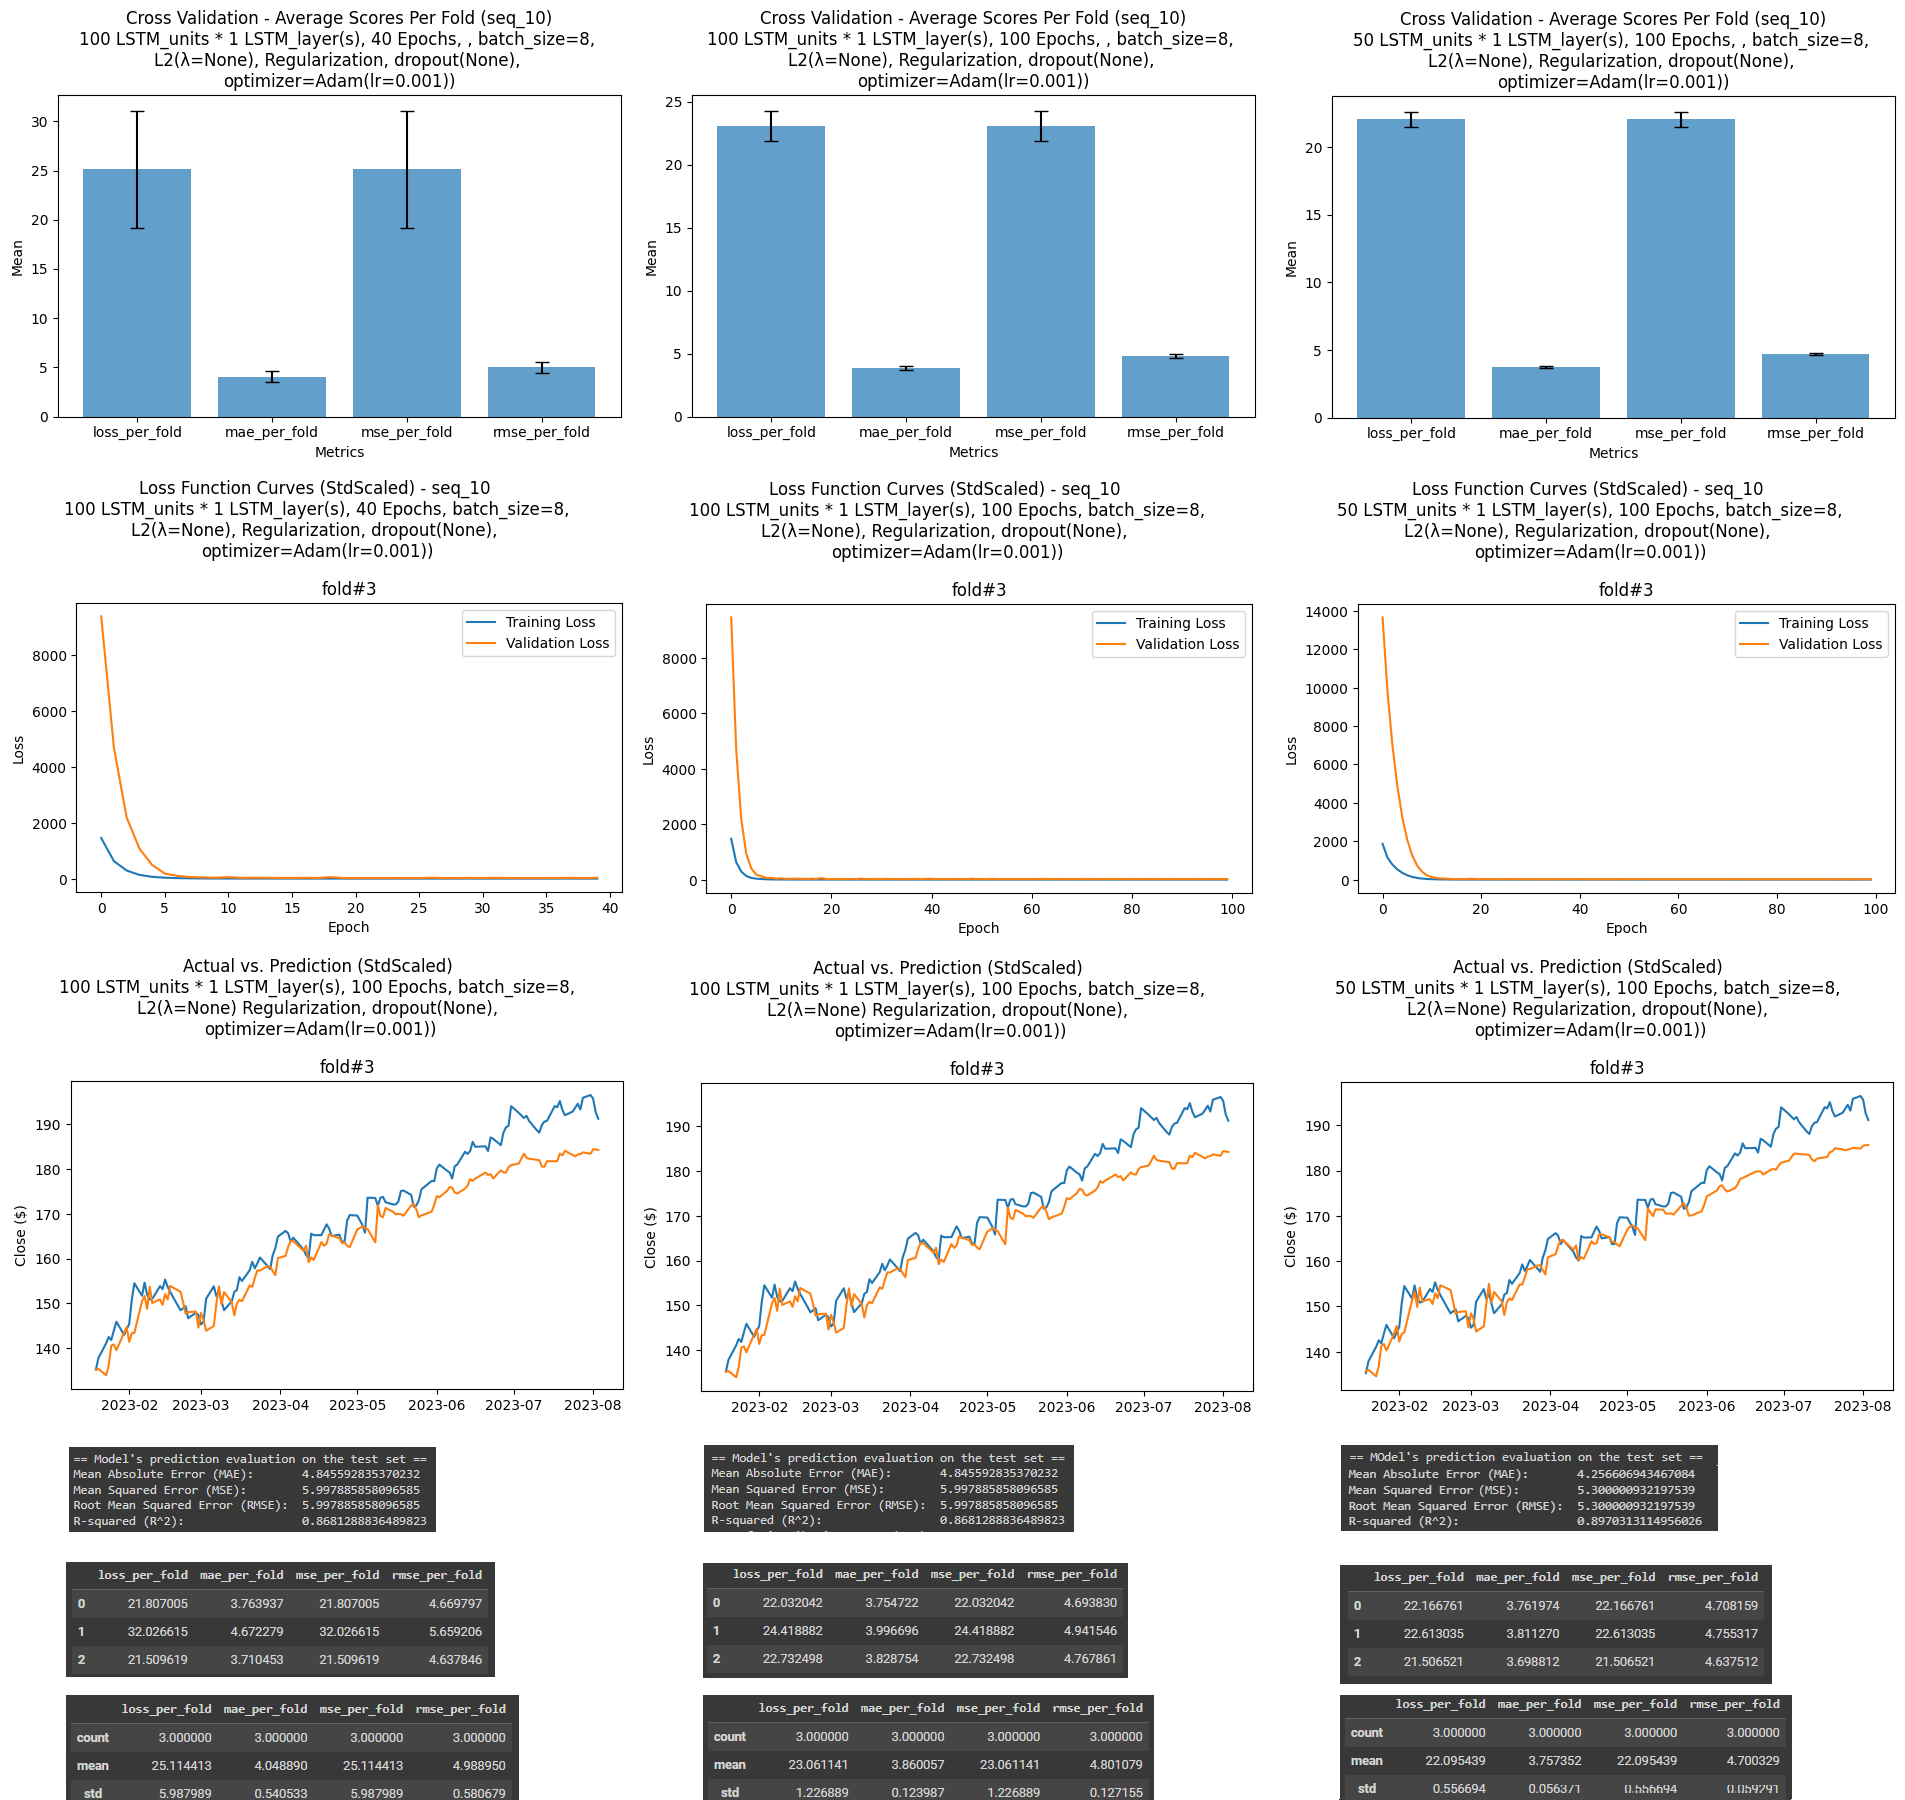

* The loss curves of training and validation data met and did not cross at any point.
* LSTM is designed to address the vanishing gradient problem by incorporating gating mechanism.
* --> No logical reason to test different optimization method or testing lower learning rate.


##### Early Stopping

* With a better understanding of potentially optimal hyperparameters that could enhance the model's performance, we will leverage the early stopping technique to meticulously fine-tune our model.
* The following is the best found hyperparameter so far which will be used to test early stopping:
    * 50 LSTM / LSTM layer * 1 LSTM layer
    * 100 Epochs
    * batch_size 8
* EarlyStopping conditions
    * monitor validation loss to decide when to stop
    * halt the training proces if (1) the loss doesn't improve by at leat 0.3 units over a period of 10 consecutive epochs and (2) the loss is below 20
        * 20: based on the val_loss of 21.5 of the best model found
        * 0.3: based on the intuition acquired from monitorig the training outputs
    * restore the model's best weights when training is stopped   

###### Model training

In [ ]:
def build_simple_lstm_model(sequence_length, num_features):
    num_features = len(df.columns)

    # Build the LSTM model
    lstm_layers = 1
    lstm_units = 50
    lambda_l2 = None
    lr_optimizer = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_optimizer)
    dropout_rate = None
    tf.random.set_seed(42)

    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(sequence_length, num_features)))   # Add an LSTM layer with 50 LSTM units (=neurons); input_shape=(10, 5) meaning 10 records each with 5 features
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=my_metrics)
    return model

In [ ]:
# From model building to model training with cross-validation
num_train = len(X_train_10) # 4877
num_test = len(X_test_10)   # 136

n_split = 3

fold_num = 1
histories = []
loss_per_fold, mae_per_fold, mse_per_fold, rmse_per_fold = [], [], [], []
for i in range(n_split, 0, -1):
    # print(i+1)
    val_end_idx = len(X_train_10)
    val_start_idx = val_end_idx - num_test
    if i == 0:
        train_start_idx = 0
    else:
        train_start_idx = num_test*(i)-1

    X_train_10_, y_train_10_ = X_train_10[train_start_idx:val_start_idx], y_train_10[train_start_idx:val_start_idx]
    X_val_10, y_val_10 = X_train_10[val_start_idx:val_end_idx], y_train_10[val_start_idx:val_end_idx]

    print(f"=================================== Fold#{fold_num} ===================================")
    print("train_start_idx", train_start_idx, "-->", "val_start_idx", val_start_idx, "-->", "val_end_idx", val_end_idx)
    print()
    print("train_:\t", X_train_10_.shape, y_train_10_.shape)
    print("val:\t", X_val_10.shape, y_val_10.shape)
    print("test:\t", X_test_10.shape, y_test_10.shape, "\n")

    # Build simple LSTM model
    sequence_length = 10
    num_features = len(df.columns)
    model = build_simple_lstm_model(sequence_length, num_features)

    # Fit the model with train-val data
    epochs = 100
    batch_size = 8
    tf.random.set_seed(42)

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.3, patience = 10, verbose=1, baseline=20, restore_best_weights=True, start_from_epoch=10)
    history = model.fit(X_train_10_, y_train_10_, validation_data=(X_val_10, y_val_10), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    histories.append(history)
    if fold_num == 3: model.save_weights('best_model_weights.h5')

    # Increase fold num
    fold_num += 1

=================================== Fold#1 ===================================
train_start_idx 407 --> val_start_idx 4741 --> val_end_idx 4877

train_:	 (4334, 10, 5) (4334,)
val:	 (136, 10, 5) (136,)
test:	 (136, 10, 5) (136,) 

Epoch 1/100
542/542 [==============================] - 8s 10ms/step - loss: 1998.6504 - mean_absolute_error: 23.1843 - mean_squared_error: 1998.6504 - root_mean_squared_error: 44.7063 - val_loss: 14231.3848 - val_mean_absolute_error: 118.7980 - val_mean_squared_error: 14231.3848 - val_root_mean_squared_error: 119.2954
Epoch 2/100
542/542 [==============================] - 4s 7ms/step - loss: 1243.0474 - mean_absolute_error: 14.3824 - mean_squared_error: 1243.0474 - root_mean_squared_error: 35.2569 - val_loss: 10214.1201 - val_mean_absolute_error: 100.4773 - val_mean_squared_error: 10214.1201 - val_root_mean_squared_error: 101.0649
Epoch 3/100
542/542 [==============================] - 4s 7ms/step - loss: 850.0029 - mean_absolute_error: 10.9857 - mean_squared_e

###### Training results

* According to the output printed during the training process, the EarlyStopping terminated the training at epoch 19, suggesting that the loss failed to show improvement of at leat 0.1 units over a period of 10 consecutive epochs.
* Whether the built-in or custom EarlyStopping class was used or whether the early stopping min_delta was changed did not make big difference to the results; the training was halted at either epoch 19 or 20.
* Notably, the earlier training result without early stopping showed that the loss curve began stabilizing before epoch 20.
* While the initial assumption was that epoch 40 might be optimal, the speculation was quite accurate.
* However, the application of early stopping proved valuable in terms of determining precisely when to conclude training, effectively saving time and resources while avaiding unnecessary continuation of the training process. wasted.

In [ ]:
# Check the best_epoch
best_epoch = early_stopping.stopped_epoch
print("Best Epoch:", best_epoch)        # best epoch is 19 (built-in EarlyStopping); 19 (Custom MyEarlyStopping class)

Best Epoch: 19


In [ ]:
# The model hyprparameters used
lstm_layers = 1
lstm_units = 50
lambda_l2 = None
lr_optimizer = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_optimizer)
dropout_rate = None

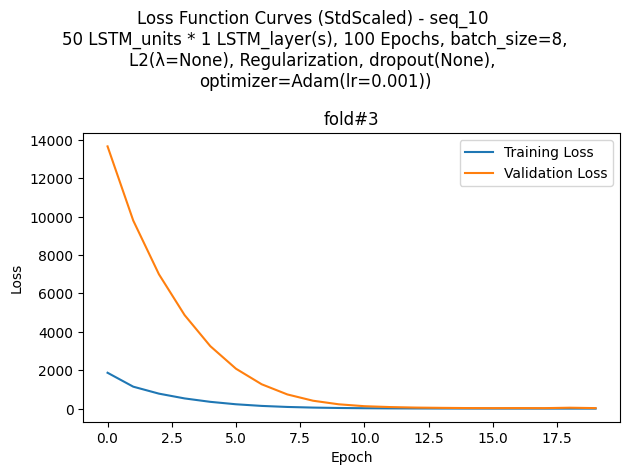

In [ ]:
# Plot both the training and test loss curves
plt.subplot(1,1,1)
plot_loss_func_curve(histories[i])
plt.title(f"fold#{fold_num-1}")
plt.suptitle(f'Loss Function Curves (StdScaled) - seq_10 \n{lstm_units} LSTM_units * {lstm_layers} LSTM_layer(s), {epochs} Epochs, batch_size={batch_size},\nL2(λ={lambda_l2}), Regularization, dropout({dropout_rate}), \noptimizer={optimizer.name}(lr={lr_optimizer}))')
plt.tight_layout()
plt.show()

###### Prediction results

In [ ]:
# Prediction
# Load the best model architecture and compile the model
best_model = build_simple_lstm_model(sequence_length, num_features)
# Load the best model's weights
best_model.load_weights('best_model_weights.h5')
# Predict
y_pred_10 = best_model.predict(X_test_10)

5/5 [==============================] - 1s 5ms/step


In [ ]:
# Calculate RMSE
print("== Model's prediction evaluation on the test set ==")
calculate_metrics(y_test_10, y_pred_10)

== Model's prediction evaluation on the test set ==
Mean Absolute Error (MAE): 	 9.09023520525764
Mean Squared Error (MSE):	 11.238064660173142
Root Mean Squared Error (RMSE):  11.238064660173142
R-squared (R^2): 		 0.5370475973335583
Out-of-Distribution Score (OOD): 0.8299251962340655


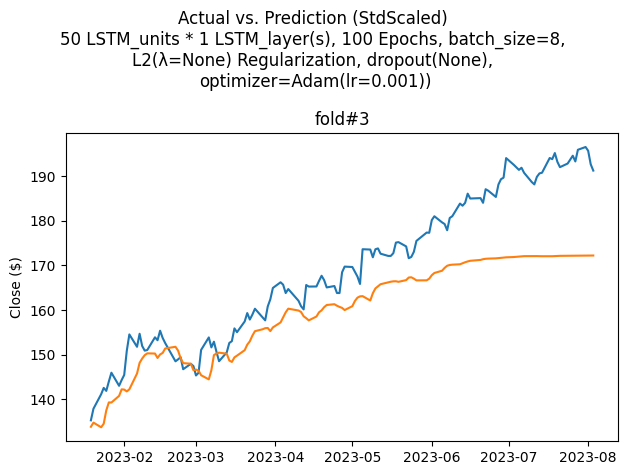

In [ ]:
y_test_date_index = y_test_data.index[sequence_length:]
plt.subplot(1,1,1)
plot_actual_vs_pred(y_test_date_index, y_test_10, y_pred_10)
plt.title("fold#3")
plt.suptitle(f'Actual vs. Prediction (StdScaled) \n{lstm_units} LSTM_units * {lstm_layers} LSTM_layer(s), {epochs} Epochs, batch_size={batch_size}, \nL2(λ={lambda_l2}) Regularization, dropout({dropout_rate}), \noptimizer={optimizer.name}(lr={lr_optimizer}))')
plt.tight_layout()
plt.show()

(Note)
* The early stopping was used expecting that it will provide reasonble number of epoch to train the model
* The results indicates that the model does not improve significantly after 20 epochs.
* It surely is valuable in terms of determining precisely when to conclude training.
* However, because the loss decreased very slowly but steadily, the EarlyStopping terminated the model at epoch 20, which lead to sub optimal performance of the model. This may be considered too early depending on the purpose of the prediction.
* The decision regarding the ideal epoch count for training this dataset will depend of the time and budget limit. Although 20 epochs seems to be a litte too early, epochs over 40 may not yield substantial benefits and may not be worth pursuing for this dataset and the purpose of the prediction.

#### Effect of different sequence length
* The unqique charateristic of an RNN
    * It is desinged to handel sequential data
    * It has a recurrent connection that allows it to remember memory of previous inputs.

* Moving averages: One of the common indicators used in stock trading
    * For near-term trends: 5, 10, 20, 50 days
    * For long-term trends: 100, 200, 500 days

* Therefore, the following sequence lengths will be set to assess the influece of the length the sequence in the model's predictive performance:
    * 5, 10, 20, 50, 100

##### Dataset

In [ ]:
X_train_5, y_train_5, X_test_5, y_test_5 = make_sequenced_train_test(5, X_train, y_train, X_test, y_test)
X_train_10, y_train_10, X_test_10, y_test_10 = make_sequenced_train_test(10, X_train, y_train, X_test, y_test)
X_train_20, y_train_20, X_test_20, y_test_20 = make_sequenced_train_test(20, X_train, y_train, X_test, y_test)
X_train_50, y_train_50, X_test_50, y_test_50 = make_sequenced_train_test(50, X_train, y_train, X_test, y_test)
X_train_100, y_train_100, X_test_100, y_test_100 = make_sequenced_train_test(100, X_train, y_train, X_test, y_test)

In [ ]:
print("When sequence_length = 5")
print("- X train shape", X_train_5.shape, "\ty train shape", y_train_5.shape)
print("- X test shape ", X_test_5.shape, "\ty test shape ", y_test_5.shape); print()
print("When sequence_length = 10")
print("- X train shape", X_train_10.shape, "\ty train shape", y_train_10.shape)
print("- X test shape ", X_test_10.shape, "\ty test shape ", y_test_10.shape); print()
print("When sequence_length = 20")
print("- X train shape", X_train_20.shape, "\ty train shape", y_train_20.shape)
print("- X test shape ", X_test_20.shape, "\ty test shape ", y_test_20.shape); print()
print("When sequence_length = 50")
print("- X train shape", X_train_50.shape, "\ty train shape", y_train_50.shape)
print("- X test shape ", X_test_50.shape, "\ty test shape ", y_test_50.shape); print()
print("When sequence_length = 100")
print("- X train shape", X_train_100.shape, "\ty train shape", y_train_100.shape)
print("- X test shape ", X_test_100.shape, "\ty test shape ", y_test_100.shape); print()

When sequence_length = 5
- X train shape (4882, 5, 5) 	y train shape (4882,)
- X test shape  (141, 5, 5) 	y test shape  (141,)

When sequence_length = 10
- X train shape (4877, 10, 5) 	y train shape (4877,)
- X test shape  (136, 10, 5) 	y test shape  (136,)

When sequence_length = 20
- X train shape (4867, 20, 5) 	y train shape (4867,)
- X test shape  (126, 20, 5) 	y test shape  (126,)

When sequence_length = 50
- X train shape (4837, 50, 5) 	y train shape (4837,)
- X test shape  (96, 50, 5) 	y test shape  (96,)

When sequence_length = 100
- X train shape (4787, 100, 5) 	y train shape (4787,)
- X test shape  (46, 100, 5) 	y test shape  (46,)



In [ ]:
# Split train dataset into train and val
len_ = len(X_train_10) - len(X_test_10)
X_train_5_, X_val_5, X_train_10_, X_val_10, X_train_20_, X_val_20, X_train_50_, X_val_50, X_train_100_, X_val_100 = X_train_5[:len_], X_train_5[len_:], X_train_10[:len_], X_train_10[len_:], X_train_20[:len_], X_train_20[len_:], X_train_50[:len_], X_train_50[len_:], X_train_100[:len_], X_train_100[len_:]
y_train_5_, y_val_5, y_train_10_, y_val_10, y_train_20_, y_val_20, y_train_50_, y_val_50, y_train_100_, y_val_100 = y_train_5[:len_], y_train_5[len_:], y_train_10[:len_], y_train_10[len_:], y_train_20[:len_], y_train_20[len_:], y_train_50[:len_], y_train_50[len_:], y_train_100[:len_], y_train_100[len_:]

print("== Train ==")
print(" X_train_5_:", X_train_5_.shape, "y_train_5_:", y_train_5_.shape,  "\n", "X_train_10_:", X_train_10_.shape, "y_train_10_:", y_train_10_.shape, "\n",
      "X_train_20_:", X_train_20_.shape, "y_train_20_:", y_train_20_.shape, "\n", "X_train_50_:", X_train_50_.shape, "y_train_50_:", y_train_50_.shape, "\n",
      "X_train_100_:", X_train_100_.shape)
print("== Validation ==")
print(" X_val_5:", X_val_5.shape, "y_val_5:", y_val_5.shape, "\n", "X_val_10:", X_val_10.shape, "y_val_10:", y_val_10.shape, "\n",
      "X_val_20:", X_val_20.shape, "y_val_20:", y_val_20.shape, "\n", "X_val_50:", X_val_50.shape, "y_val_50:", y_val_50.shape, "\n",
      "X_val_100:", X_val_100.shape)

== Train ==
 X_train_5_: (4741, 5, 5) y_train_5_: (4741,) 
 X_train_10_: (4741, 10, 5) y_train_10_: (4741,) 
 X_train_20_: (4741, 20, 5) y_train_20_: (4741,) 
 X_train_50_: (4741, 50, 5) y_train_50_: (4741,) 
 X_train_100_: (4741, 100, 5)
== Validation ==
 X_val_5: (141, 5, 5) y_val_5: (141,) 
 X_val_10: (136, 10, 5) y_val_10: (136,) 
 X_val_20: (126, 20, 5) y_val_20: (126,) 
 X_val_50: (96, 50, 5) y_val_50: (96,) 
 X_val_100: (46, 100, 5)


##### Model training
* The best model found
    * 1 LSTM layer
    * 50 LSTM unit per layer
    * batch_size = 8
    * 40 ~ epochs
* For the purpose of testing different sequence lengths on the model performance, the model is trained based on following conditions:
    * 1 LSTM layer
    * 50 LSTM unit per layer
    * batch_size = 8
    * 100 epochs (instead of 40) <-- To observe the full picture:
    * 1-fold cross validation (instead of 3-fold) <-- Due to the limit in time     

In [ ]:
# From model building to model training with different sequence lengths
num_features = len(df.columns)

# In the for loop below, the following seven lists will be used to iterate over different sequence lengths:
seq_len_list = [5, 10, 20, 50, 100]
X_trains_ = [X_train_5_, X_train_10_, X_train_20_, X_train_50_, X_train_100_]
X_vals = [X_val_5, X_val_10, X_val_20, X_val_50, X_val_100]
X_tests = [X_test_5, X_test_10, X_test_20, X_test_50, X_test_100]
y_trains_ = [y_train_5_, y_train_10_, y_train_20_, y_train_50_, y_train_100_]
y_vals = [y_val_5, y_val_10, y_val_20, y_val_50, y_val_100]
y_tests = [y_test_5, y_test_10, y_test_20, y_test_50, y_test_100]

# Initialize a dictionary to store results for different sequence lengths
diff_seqs_results = {"seq_length": seq_len_list,
    "history": [],
}

for seq_len, X_train_, y_train, X_val, y_val, X_test, y_test in zip(seq_len_list, X_trains_, y_trains_, X_vals, y_vals, X_tests, y_tests):
    print("\n\n\n\n==================================================================================================")
    print(f"    =================================== Sequence Length {seq_len} ===================================")
    print("==================================================================================================\n\n")

    # Build simple LSTM model
    lstm_layers = 1
    lstm_units = 50
    lambda_l2 = None
    lr_optimizer = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_optimizer)
    dropout_rate = None
    tf.random.set_seed(42)

    my_metrics = [MeanAbsoluteError(), MeanSquaredError(), RootMeanSquaredError()]
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(seq_len, num_features)))   # Add an LSTM layer with 50 LSTM units (=neurons); input_shape=(10, 5) meaning 10 records each with 5 features
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=my_metrics)
    model_config = model.to_json()
    with open('model_config.json', 'w') as config_file:
        config_file.write(model_config)

    # Fit the model with train-val data
    epochs = 100
    batch_size = 8
    tf.random.set_seed(42)

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, restore_best_weights=True, start_from_epoch=10)
    history = model.fit(X_train_, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)
    model.save_weights(f'best_model_weights_seq{seq_len}.h5')

    # Save the results into the list
    diff_seqs_results["history"].append(pd.DataFrame(history.history))





    =================================== Sequence Length 5 ===================================


Epoch 1/100
593/593 [==============================] - 8s 8ms/step - loss: 1791.8357 - mean_absolute_error: 21.3321 - mean_squared_error: 1791.8357 - root_mean_squared_error: 42.3301 - val_loss: 13555.7656 - val_mean_absolute_error: 115.8957 - val_mean_squared_error: 13555.7656 - val_root_mean_squared_error: 116.4292
Epoch 2/100
593/593 [==============================] - 3s 5ms/step - loss: 1067.3444 - mean_absolute_error: 12.6263 - mean_squared_error: 1067.3444 - root_mean_squared_error: 32.6702 - val_loss: 9583.0615 - val_mean_absolute_error: 97.2580 - val_mean_squared_error: 9583.0615 - val_root_mean_squared_error: 97.8931
Epoch 3/100
593/593 [==============================] - 3s 5ms/step - loss: 713.8083 - mean_absolute_error: 9.3506 - mean_squared_error: 713.8083 - root_mean_squared_error: 26.7172 - val_loss: 6681.8452 - val_mean_absolute_error: 80.9808 - val_mean_squared_error: 668

###### Training results

The training took approximately 2 hours to run the code above without GPU.

It is necessary to save the results as follows to prevent running the code again.

In [ ]:
temp = pd.DataFrame(pd.DataFrame(diff_seqs_results))
temp.to_csv("results/diff_seqs_results_epoch100.csv", index=False)
temp.set_index('seq_length', inplace=True)
diff_seqs_results = pd.read_csv("results/diff_seqs_results_epoch100.csv")
diff_seqs_results.index = seq_len_list
diff_seqs_results.index.name = "seq_length"

(Note)

It is demonstrated that as the sequence length extends from 5 to 20, there is a notable reduction in validation metrics. However, beyond a sequence length of 20, these metrics befin to rise again, resembling the values observed with a sequence length of 5.

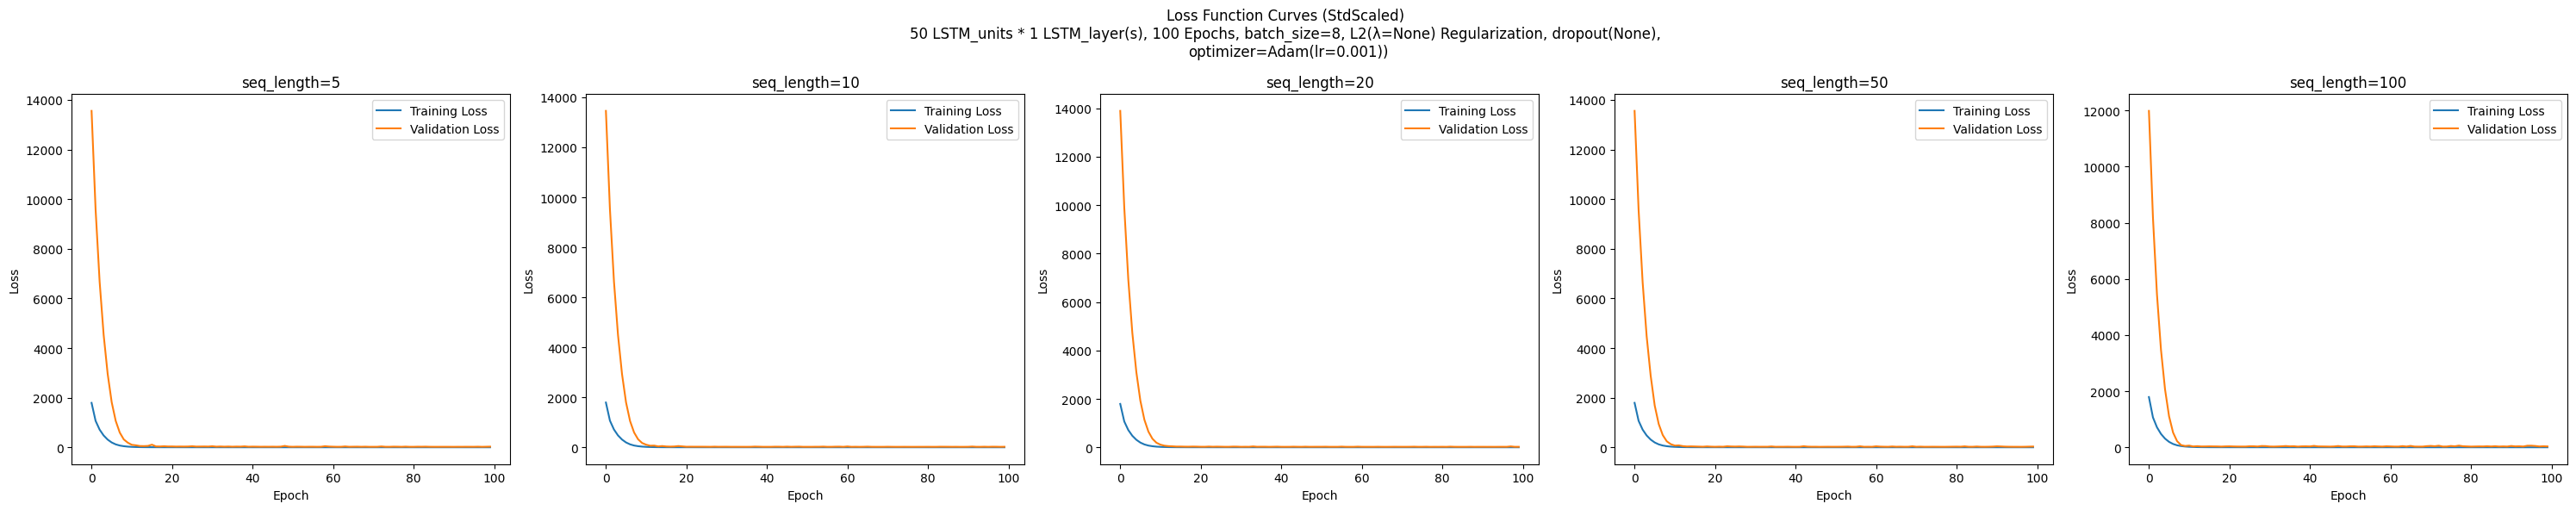

In [ ]:
# Plot both the training and test loss curves
fig, axes = plt.subplots(1, len(seq_len_list), figsize=(30, 6))
axes = axes.flatten()   # Flatten the axes array to simplify indexing
histories = [history_seq_5, history_seq_10, history_seq_20, history_seq_50, history_seq_100]
for (i, seq_len), history in zip(enumerate(seq_len_list),histories):
    ax = axes[i]  # Get the current subplot
    ax.plot(history_seq_5["loss"], label='Training Loss')        # diff_seqs_history
    ax.plot(history["val_loss"], label='Validation Loss')    # diff_seqs_history
    ax.set_title(f'seq_length={seq_len}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
fig.suptitle(f'Loss Function Curves (StdScaled) \n{lstm_units} LSTM_units * {lstm_layers} LSTM_layer(s), {epochs} Epochs, batch_size={batch_size}, L2(λ={lambda_l2}) Regularization, dropout({dropout_rate}), \noptimizer={optimizer.name}(lr={lr_optimizer}))')
plt.tight_layout()
plt.show()

(Note)

The loss curves for various sequence lengths exhibit a similar pattern, except for sequence length 100 where the loss curve stabilized aproximately 2 epochs ealier than othrs.

###### Prediction results

In [ ]:
# Load weights to the model architecture
y_preds = []
for seq_len, X_test in zip(seq_len_list, X_tests):
    with open('model_config.json', 'r') as config_file:
        loaded_model_config = config_file.read()
    reproduced_model = model_from_json(loaded_model_config)
    model.load_weights(f'best_model_weights_seq{seq_len}.h5')
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

2/2 [==============================] - 0s 10ms/step


In [ ]:
y_preds[0][0], y_preds[1][0]

(array([132.93195], dtype=float32), array([134.69322], dtype=float32))

In [ ]:
# Calculate RMSE
# (Caution!!) Need to flattening the y_pred to 1D array to match the shape of y_test before metrics calculation
def calculate_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test.flatten(), y_pred.flatten())
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

results_per_seq = []
for seq_len, y_test, y_pred in zip(seq_len_list, y_tests, y_preds):
    mae, mse, rmse, r2= calculate_metrics(y_test, y_pred)
    eval_results = {"Sequence_Length":[seq_len], "MAE": [], "MSE":[], "RMSE":[], "R2":[]}
    eval_results["MAE"].append(mae)
    eval_results["MSE"].append(mse)
    eval_results["RMSE"].append(rmse)
    eval_results["R2"].append(r2)
    pd.DataFrame(eval_results).to_csv(f"results/diff_seqs_test/seq{seq_len}_epochs{epochs}_batch_size{batch_size}_lstmUnits{lstm_units}_y_pred.csv")
temps = []
for seq_len in seq_len_list:
    temp = pd.read_csv(f"results/diff_seqs_test/seq{seq_len}_epochs{epochs}_batch_size{batch_size}_lstmUnits{lstm_units}_y_pred.csv")
    temps.append(temp)
diff_seqs_eval = pd.concat([temps[0], temps[1], temps[2], temps[3], temps[4]], axis=0, ignore_index=True)
diff_seqs_eval.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
diff_seqs_eval.set_index('Sequence_Length', inplace=True)
diff_seqs_eval

,MAE,MSE,RMSE,R2
Sequence_Length,,,,
5,4.013429,25.797146,5.079089,0.914850
10,4.457873,30.653754,5.536583,0.887633
20,3.693950,20.967113,4.578986,0.910120
50,4.730524,35.193991,5.932452,0.758539
100,7.592273,63.363446,7.960116,-1.053464


<ipython-input-96-a8e6451b0d6e>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues', len(diff_seqs_results.T)*2)


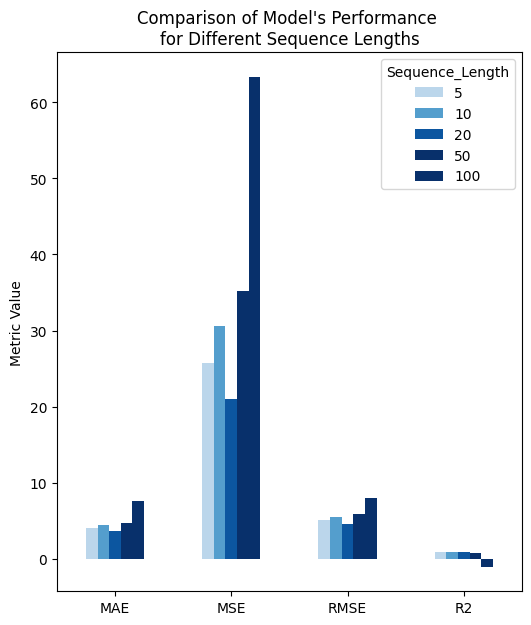

In [ ]:
# Visualizing validation loss, mae, mse, rmse for the different sequence lengths
cmap = cm.get_cmap('Blues', len(diff_seqs_results.T)*2)
new_colors = [cmap(i*2+2) for i in range(len(diff_seqs_results.T))]
new_cmap = cm.colors.ListedColormap(new_colors)

diff_seqs_eval.T.plot(kind='bar', figsize=(6, 7), colormap=new_cmap)
plt.title('Comparison of Model\'s Performance \nfor Different Sequence Lengths')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.show()

(Note)

Performance evaluation metrics were lowest lowest when sequence length was 20.

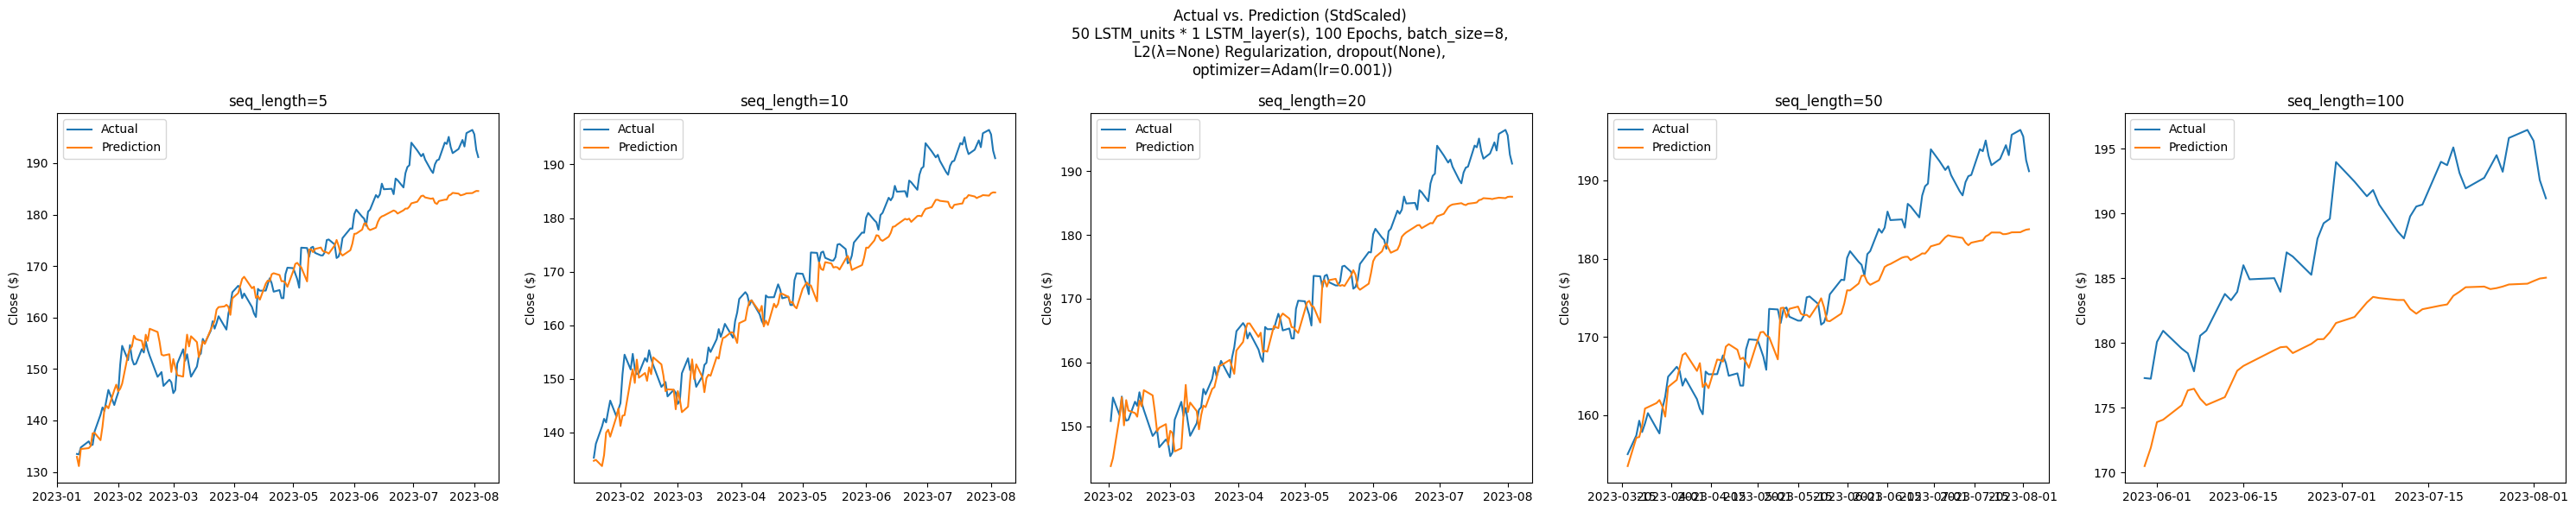

In [ ]:
# Plot actual vs. predicted stock prices
fig, axes = plt.subplots(1, len(seq_len_list), figsize=(30, 6))
axes = axes.flatten()
for (i, seq_len), y_test, y_pred in zip(enumerate(seq_len_list), y_tests, y_preds):
    y_test_date_index = y_test_data.index[seq_len:]
    ax = axes[i]
    ax.plot(y_test_date_index, y_test, label='Actual')
    ax.plot(y_test_date_index, y_pred, label='Prediction')
    ax.set_title(f'seq_length={seq_len}')
    ax.set_ylabel('Close ($)')
    ax.legend()
fig.suptitle(f'Actual vs. Prediction (StdScaled) \n{lstm_units} LSTM_units * {lstm_layers} LSTM_layer(s), {epochs} Epochs, batch_size={batch_size}, \nL2(λ={lambda_l2}) Regularization, dropout({dropout_rate}), \noptimizer={optimizer.name}(lr={lr_optimizer}))')
plt.tight_layout()
plt.show()

(Note)

The actual vs. predicted plot reflects the evaluation metrics bar plot, where sequence length 20 demonstrates the predicted close price plotted close to the actual price plot.

# Results and Discussion

The purpose of this project was to predict tomorrow's close price of Apple in 2023 using three different models trained with 20 years worth historical stock price data (2023-2022). The algorithms used to train models were K nearest neighbor regressor, Random Forest, and Long-short term memory algorithms.

The basic feature variables used to predict the target was OLHC (open, low, hight and close) data and the volume traded. Since stock price is notorious for its unpredictable randomness and noise, it is true that the five features used are not ideally the best feature variables to predict the future. It is stated by many others that adding other relevant features such as technical indicators (e.g. moving average, Bollinger bands, etc.), fundamental data that captures the company's performance (e.g. EPS, P/E, PBE, EBITDA, etc), economic indicators (e.g. inflation rates, GDP growth, interest rates, etc), and even company's announcement and news including buzz news on social media. For the purpose of this project, however, the effect of additional features were tested in the shallow learning as it takes shorter compared to deep learning. In the deep learning the data was limited to the five basic variabels (OLHC and volume).

Given that the data used was in the form of a time series, the primary focus during data preprocessing was on preserving the sequential information. This ensured that the data was appropriately prepared before being used as inputs to train the model. When splitting the data into train and test dataset. The conventional train_test_split function of sklearn was not used as it would mix the order of the data. Instead we splitted so that train is before 2023 and test is 2023 in time. When performing train-validation split for k-fold validation, sklearn's TimeSeriesSplit or a custom splitting with the same concept of TImeSeriesSplit was used.

In the shallow learning section of this project, we tested the effect of other features that are widely known to influecd or be influenced by stock price changes. KNN and Random Forest regressors were used because they were identified as the most widely used regressors amongst other shallow learning regressors in kaggle and other documents. The initial expection was that adding more features would improve the model's performance. Eleven different features were tested to see whether the model performs better when one of them was added to the feature dataset. Amongst them, four features - S&P500 futures, Nasdaq futures, VIX, and Crude Oil - were observed to improve the model's performance. Combining all of these factors, however, did not lead to an improvement in the model's performance, contrary to what was expected. An extensive GridSearch was performed to find the betther hyperparameter combination, however, model that used the best combination selected did not perform better than the origial model. When plotted the predicted price against the actual price, the there was a tendency of the model not being able to predict the latter period of the test dataset, indicating that the model needs to be trained with data spaning until at least 6 months before applying the model to predict tomorrow's price.

LSTM stands apart from KNN and Random Forest not only due to its status as a deep learning algorithm but also its role as a recurrent neural network (RNN) designed to capture sequential data. This unique architecture makes it particularly well-suited for time-series forecasting tasks, including predicting stock prices.

When using the LSTM to train the model, it was revealed that the model tends to underfit rather than to overfit. The stock prediction itself is not an easy task, but it can be speculated that the periods of the data used and the feature selected was not enough to optimize the model to its best potential. Recognizing the limitations in enhancing model performance, various hyperparameters were systematically tested. Initially, the goal was to enhance model interpretability by introducing a more intricate architecture, achieved by either increasing the number of cells per layer or adding an additional layer. Elevating the cell count led to a moderate improvement in performance; for instance, augmenting the cell number from 50 to 100 decreased the MAE from 4.84 to 4.45. However, further increasing the count to 200 resulted in a performance decline, suggesting that while more units might train better, such an increase doesn't necessarily translate to improvements, contingent on the characteristics of the training data. Although exploration of different quantities of LSTM units in the second layer was not conducted, introducing an extra layer with 50 units atop the initial LSTM layer (also with 50 units) did not yield performance enhancement, contrary to initial expectations. This outcome is speculated to arise from the relatively modest and simple nature of the training data.

Subsequently, various batch sizes were subjected to testing. In general, bigger batch size entail longer epoch training times, although typically facilitating faster convergence and improved generalization. However, interestingly, the result indicated that smaller batch size contributed to an earlier stabilization of the loss curve and enhanced predictive performance. This outcome raises the possibility that batch sizes beyond a certain thereshold might have constrained the model within subpotimal local minima. Consequenctly, the decision to reduce the batch size appeared to yield better performance by allowing it to escape from these less favorable minima.

With the best number of LSTM units and batch size found, the model was train with the combination of the two best hyperparameters. However, contrary to the expectation that the two would have add-on effects and improve the performance even furthre, it rather lowered the performance, indicating that the combination of the best hyperparameters may not always mean the best outcome.

After experimenting with various combinations of hyperparameters, it was established that the batch size of eight in conjuction with a single-layer LSTM consisting fifty units yields the best performance among the tested configurations. Using this specific setup, an attempt to minimize the epoch number was made through early stopping of training. To achieve this, Keras EarlyStopping class was used to create callbacks. The early stopping stopped the training a little too early at 19. This aligns with the observation that the loss curve begins to stabilize around 10th epoch. Given the critical nature of stock price forcasting, it is adivisable to train for more epochs, while recognizing that exceeding 100 epochs might lead to unnecessary computational cost.

Having determined that the optimal number of epochs is 100, the influence of varying sequence lengths was investigated to fully exploit the strengths of the LSTM model. The sequence lengths tested included 5, 10, 20, 50, 100, and 200, representing commonly utilized moving averages in stock price prediction. Under same conditions, sequence length of 20 showed the best performance at MAE of 3.69 and the sequence length of 100 at 7.59. Compared to the sequence length of 10 that we have been using to tune the hyperparameters thus far, it was 18 % reduction. Thus the final set of hyperparameters were (1) sequence_length=20, (2) epoch=100, (3) batch_size=8, (4) a single LSTM layer comprising 50 units.


# Other Methods Used in Time-Series Forcasting

Here are some other methods that can be considered when predicting with time-series data such as stock price:
* More traditional statistics-based methods
    * e.g. ARIMA(X), SARIMA(X)
        * Particularly useful with data that shows autocorrelation, seasonality, and trend patterns.
        * Often used when the available data is limited and when clear patterns can be captured
* Shallower algorithms  
    * e.g. Ensemble methods including Random FOrest, Gradient Boosting
        * Improving the forecasting accuracy and robustness using diverse individual models by compensating the errors made by one model by others
    * e.g. Prophet
        * Relatively simple and user-friendly method developed by Facebook, is particularly well-suited for forcasting time-series data with stron patterns of seasonality, holidays or other recurring pattern.
* Recurrent Neural Networks
    * e.g. LSTM
        * Designed to chapture the long-term dependencies in sequenced and time-seires data
    * e.g. GRU
        * Similar to LSTM but computationally less expensive due to simpler structure of the algorithm

# Summary

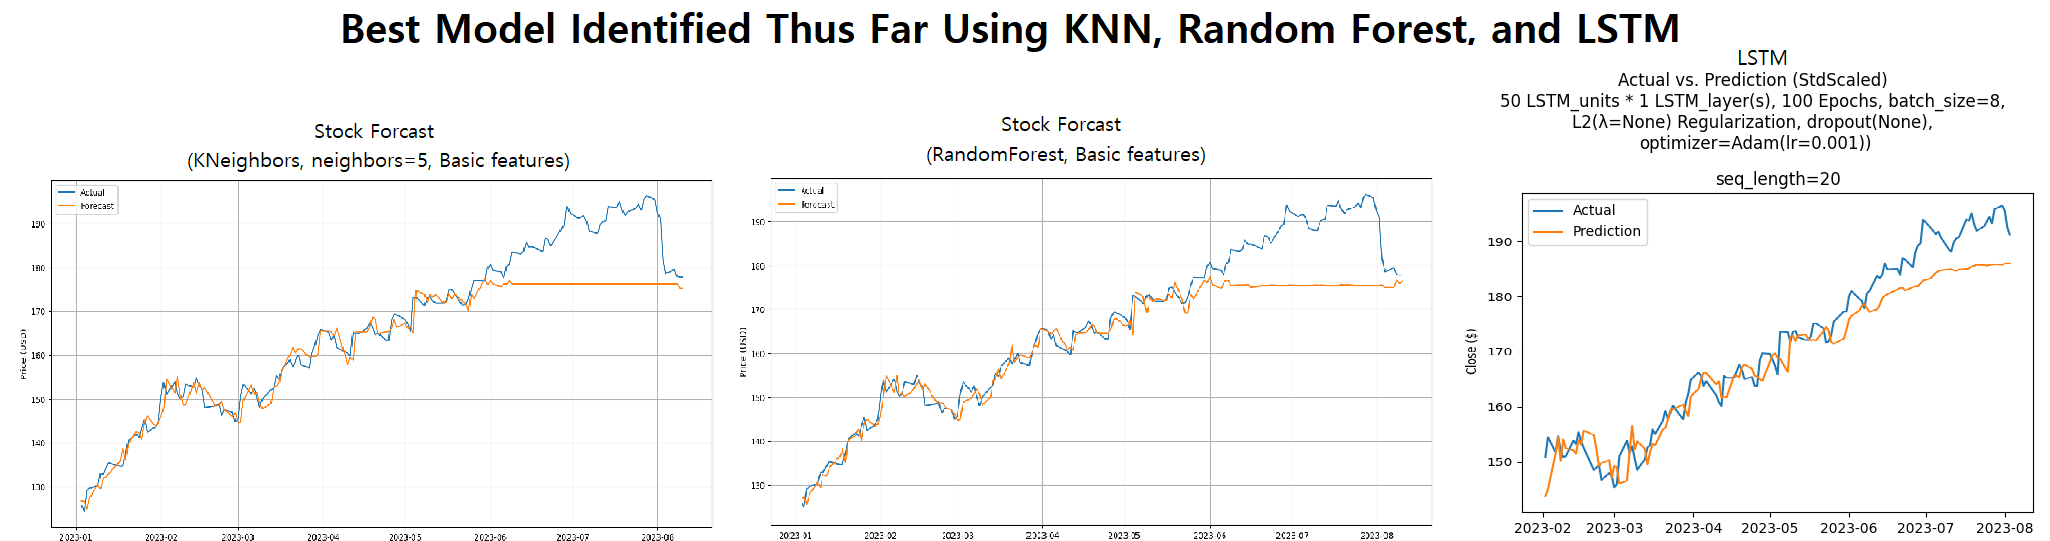

We used three distinct machine learning algorithms - KNN, Random Forest and LSTM - and trained them with around 20 years of Apple stock price history (OLHC and volume information), spanning from 2003 to 2022, to predict the tomorrow's price starting from 2023. Across all three models, there was a tendency of the models to exhibit relatively accurate predictions during the initial six months (i.e. January to June 2023), but as time progressed beyond this period, the prediction erorrs tended to escalate. Visualizing the predicted prices against the actual prices, it became evident that the predicted values reached a plateau as the actual prices continued to rise further.

With KNN and Random Forest algorithms, an exploration was conducted to assess the impact of incorporating additional relevant features, Of the additional features tested, S&P500 futures, Nasdaq futures, VIX, and Crude Oil indicators enhanced the model performance when added individually. However, when all of these features were added together with the basic features, the performance degraded, suggesting the combination of seemingly advantageous elements may not always result in the most optimal outcome.

Deep learning models with LSTM layer, showed the similar pattern of relatively good accuracy in the first 6 months although the error started to increase as the time processed beyond 6 months. After thorough tuning of hyper parameters including batch size, the number of LSTM units per layer and the number of LSTM layers, the model's performance enhanced, decreasing the MAE from 4.84 to 4.26. Leveraging this optimized configuration, the effect of different lengths of sequences on performance was further examined, in order to maximize the strength of recurrent nature of LSTM model. The experiment revealed that a sequence length of 20 performs best with the specified hyperparameter setup. As a result, the tuning of the model's hyperparameters and deciding the length of seqeunces fed into the model improved the performance of the model by 24 % based on MAE compared to the inital model whithoug tuning (initial model with MAE of 4.84, the best model with 3.96).

While the LSTM model demonstrated improved performance compared to KNN or Random Forest models based on the evaluation metrics, the tendency toward lagging forcasts raises concerns about relying solely on the model as the decision making tool.